# Dog Inpainting

## Import bibliotek

In [11]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm

## Konfiguracja parametrów

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
image_size = 64
batch_size = 32
epochs = 20
learning_rate = 1e-3
mask_fraction_range = (0.15, 0.3)

data_dir = "./archive"

## Przetwarzanie wstępne

In [13]:
class DogDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.image_files = []
        for root, _, files in os.walk(root_dir):
            self.image_files.extend([os.path.join(root, f) for f in files if f.endswith('.jpg')])

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        image = cv2.resize(image, (image_size, image_size))
        image = image.astype(np.float32) / 255.0

        # Mask generation
        mask = np.zeros((image_size, image_size), dtype=np.float32)
        mask_fraction = np.random.uniform(*mask_fraction_range)
        mask_size = int(image_size * mask_fraction)
        top = np.random.randint(0, image_size - mask_size)
        left = np.random.randint(0, image_size - mask_size)
        mask[top:top + mask_size, left:left + mask_size] = 1

        masked_image = image * (1 - mask)
        return (
            torch.tensor(masked_image).unsqueeze(0),
            torch.tensor(image).unsqueeze(0),
            torch.tensor(mask).unsqueeze(0)
        )

In [14]:
train_dataset = DogDataset(os.path.join(data_dir, "train"))
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = DogDataset(os.path.join(data_dir, "test_200_single_img"))
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

## Definicja modelu autokodera

In [15]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU()
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [16]:
model = Autoencoder().to(device)
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

## Trening

In [17]:
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for masked_images, original_images, masks in tqdm(train_loader):
        masked_images = masked_images.to(device)
        original_images = original_images.to(device)
        masks = masks.to(device)

        outputs = model(masked_images)
        loss = loss_fn(outputs * masks, original_images * masks)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch + 1}/{epochs}], Loss: {running_loss / len(train_loader):.4f}")

100%|██████████| 571/571 [02:55<00:00,  3.26it/s]


Epoch [1/20], Loss: 0.0011


100%|██████████| 571/571 [00:26<00:00, 21.31it/s]


Epoch [2/20], Loss: 0.0007


100%|██████████| 571/571 [00:25<00:00, 22.23it/s]


Epoch [3/20], Loss: 0.0007


100%|██████████| 571/571 [00:26<00:00, 21.40it/s]


Epoch [4/20], Loss: 0.0006


100%|██████████| 571/571 [00:25<00:00, 22.35it/s]


Epoch [5/20], Loss: 0.0006


100%|██████████| 571/571 [00:27<00:00, 20.55it/s]


Epoch [6/20], Loss: 0.0006


100%|██████████| 571/571 [00:25<00:00, 22.79it/s]


Epoch [7/20], Loss: 0.0006


100%|██████████| 571/571 [00:25<00:00, 21.97it/s]


Epoch [8/20], Loss: 0.0006


100%|██████████| 571/571 [00:31<00:00, 18.22it/s]


Epoch [9/20], Loss: 0.0006


100%|██████████| 571/571 [00:34<00:00, 16.35it/s]


Epoch [10/20], Loss: 0.0006


100%|██████████| 571/571 [00:34<00:00, 16.35it/s]


Epoch [11/20], Loss: 0.0006


100%|██████████| 571/571 [00:36<00:00, 15.68it/s]


Epoch [12/20], Loss: 0.0006


100%|██████████| 571/571 [00:31<00:00, 18.20it/s]


Epoch [13/20], Loss: 0.0006


100%|██████████| 571/571 [00:27<00:00, 21.02it/s]


Epoch [14/20], Loss: 0.0006


100%|██████████| 571/571 [00:30<00:00, 19.01it/s]


Epoch [15/20], Loss: 0.0006


100%|██████████| 571/571 [00:28<00:00, 20.23it/s]


Epoch [16/20], Loss: 0.0005


100%|██████████| 571/571 [00:27<00:00, 20.99it/s]


Epoch [17/20], Loss: 0.0005


100%|██████████| 571/571 [00:29<00:00, 19.62it/s]


Epoch [18/20], Loss: 0.0005


100%|██████████| 571/571 [00:30<00:00, 18.58it/s]


Epoch [19/20], Loss: 0.0005


100%|██████████| 571/571 [00:26<00:00, 21.16it/s]

Epoch [20/20], Loss: 0.0005


## Ewaluacja

In [18]:
def inpaint_image(model, image, mask):
    model.eval()
    with torch.no_grad():
        output = model(image.unsqueeze(0).to(device))
        inpainted_image = output.squeeze(0).cpu()
        result = image * (1 - mask) + inpainted_image * mask
        return result

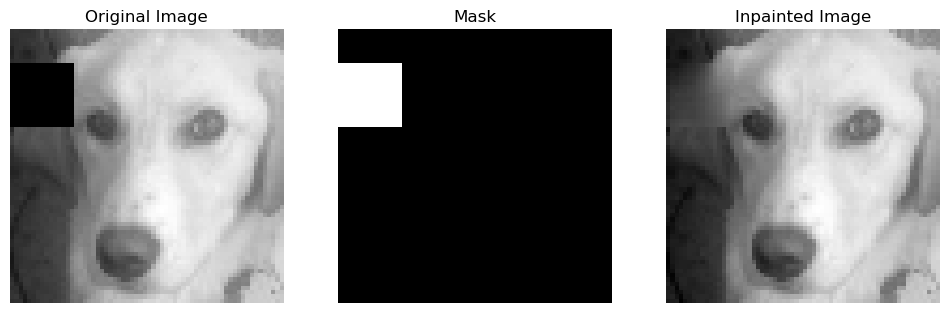

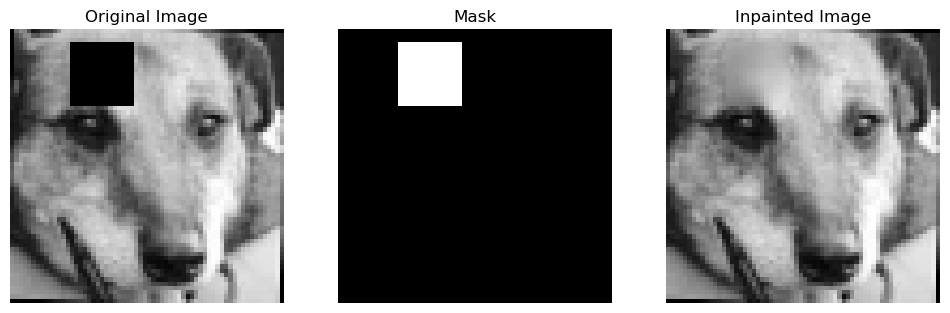

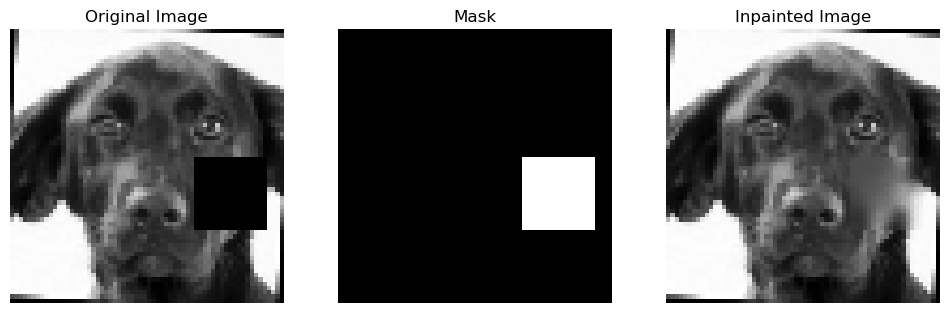

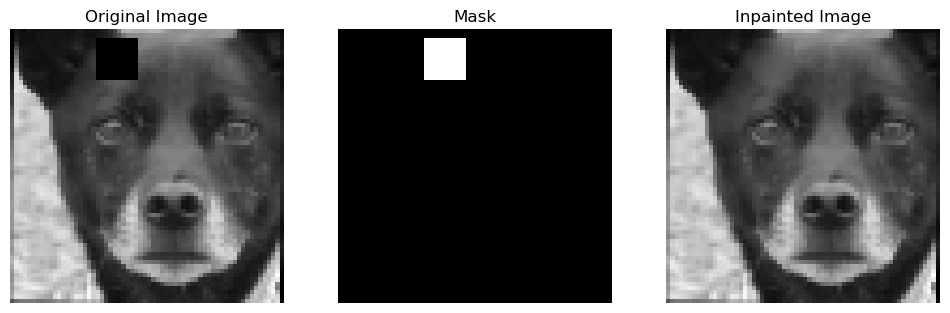

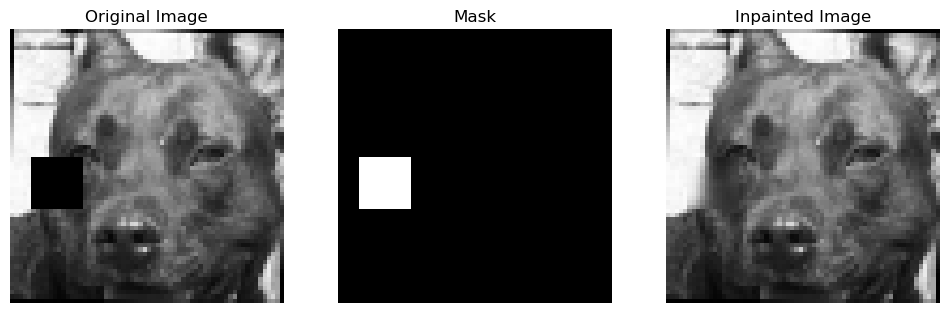

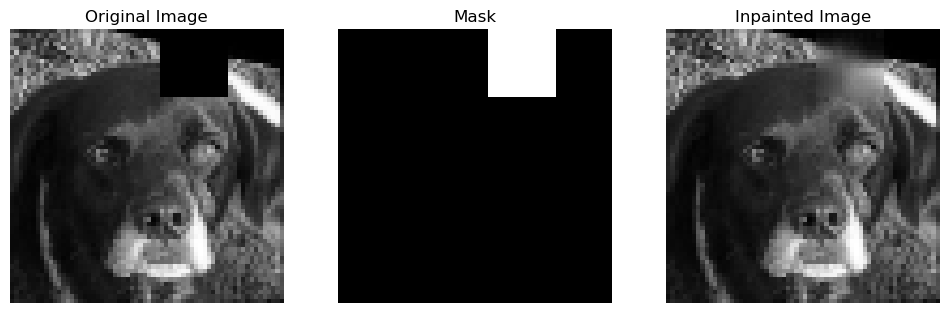

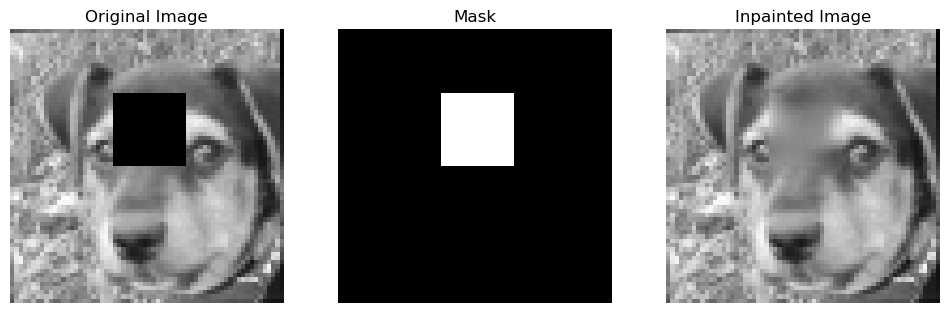

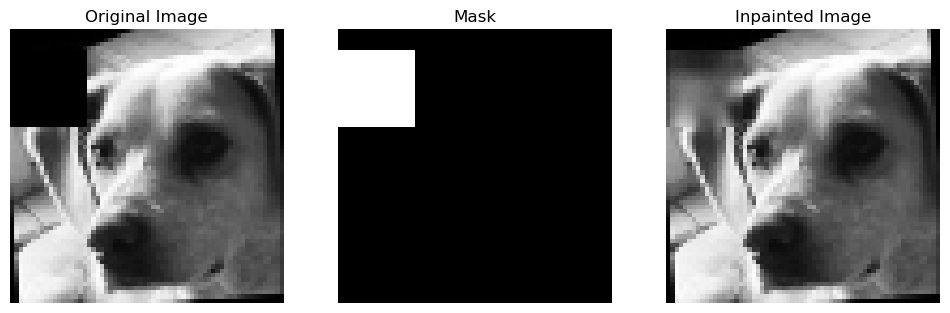

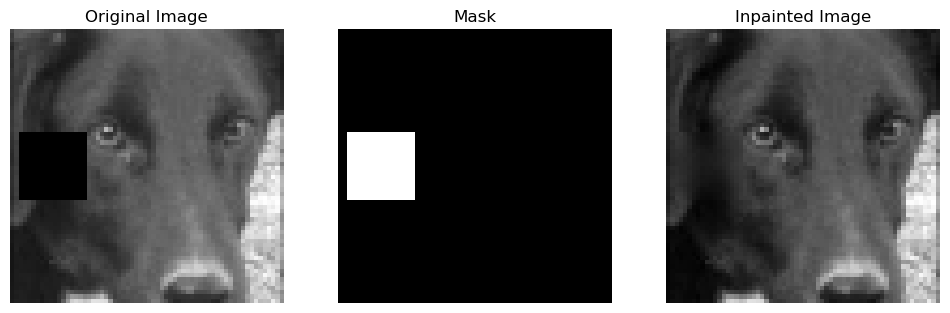

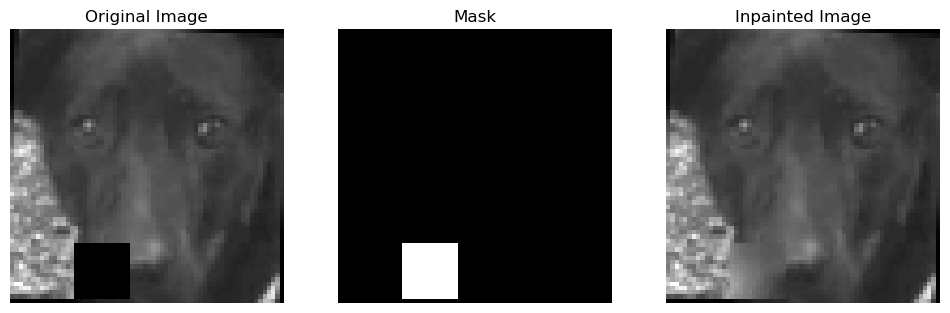

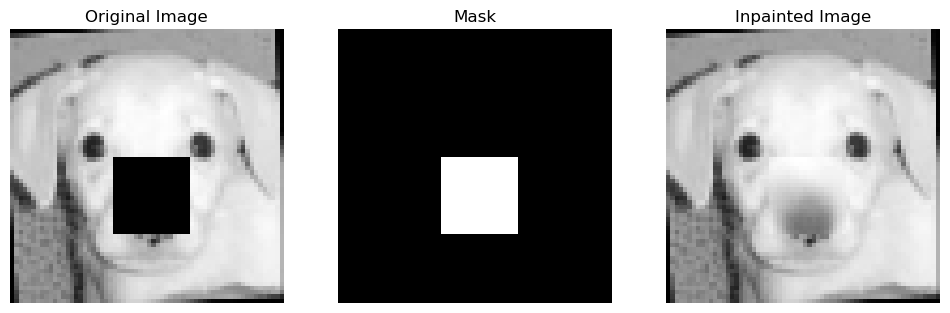

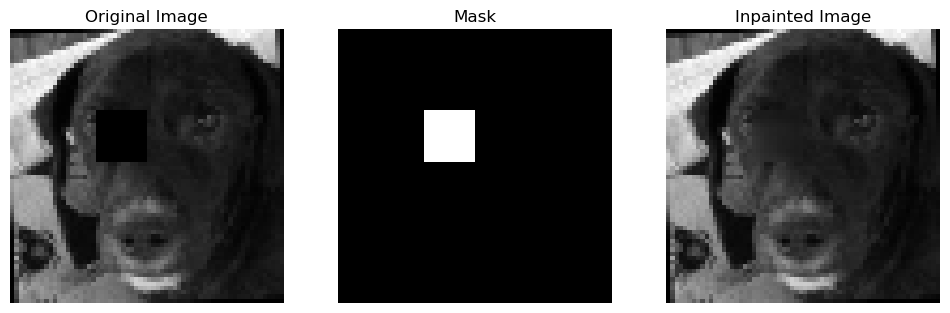

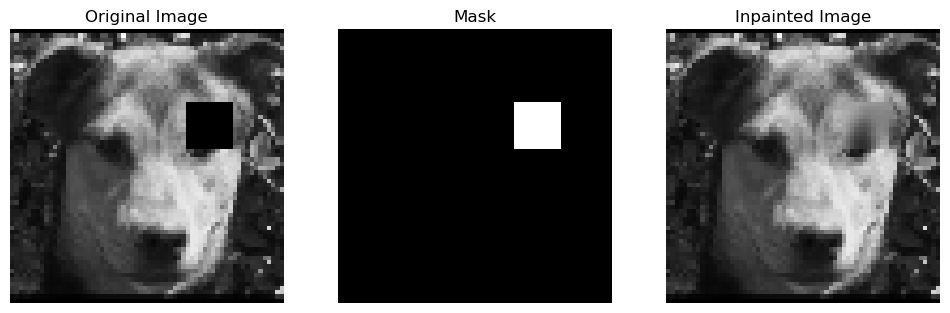

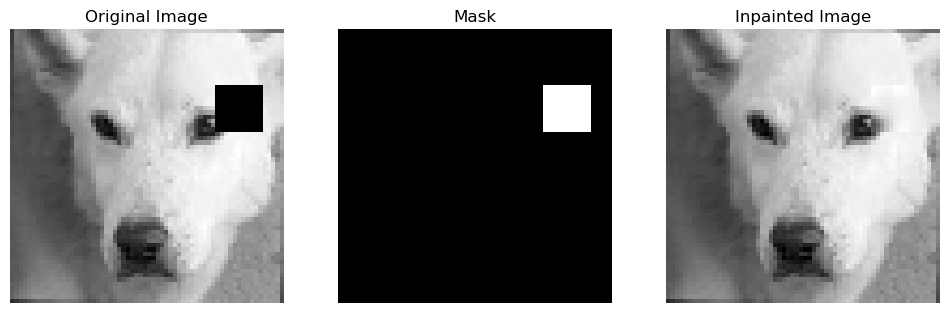

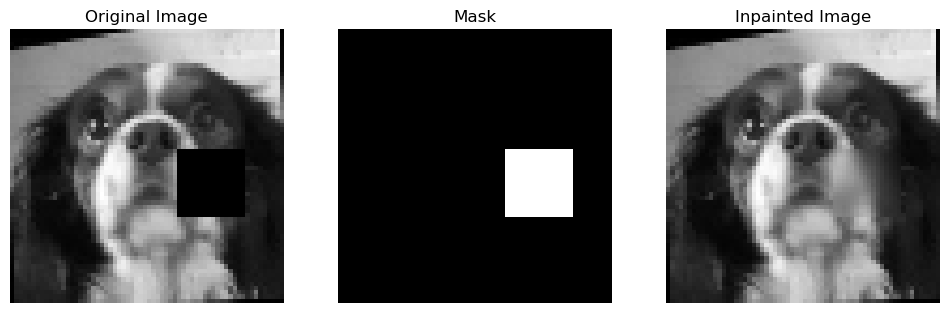

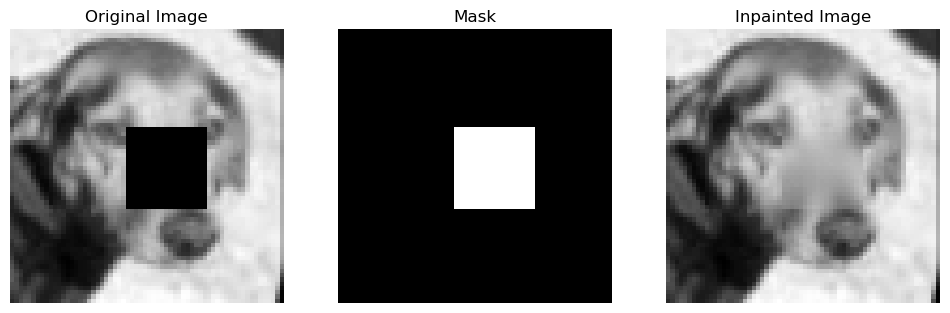

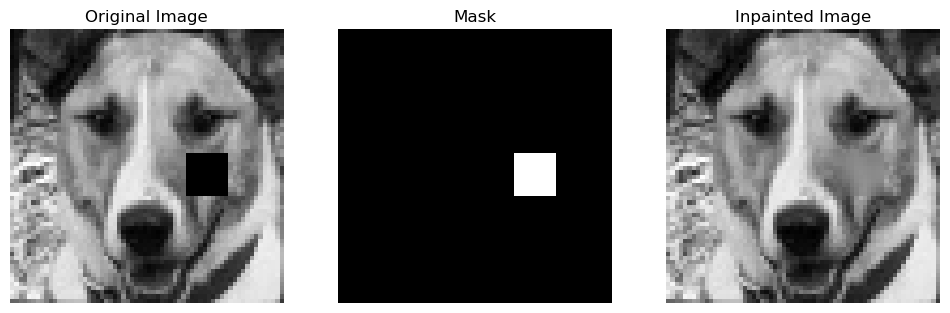

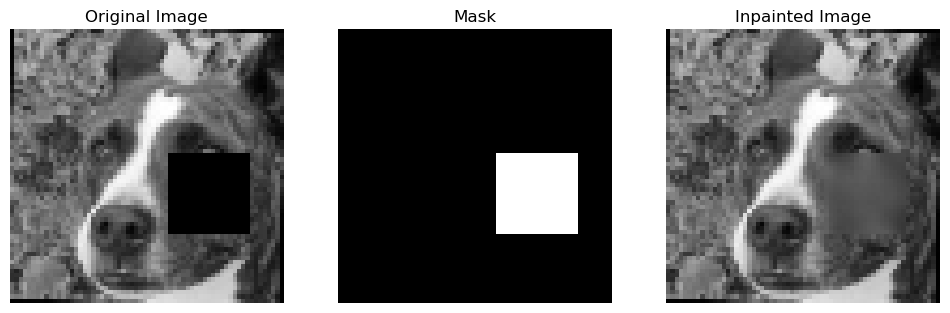

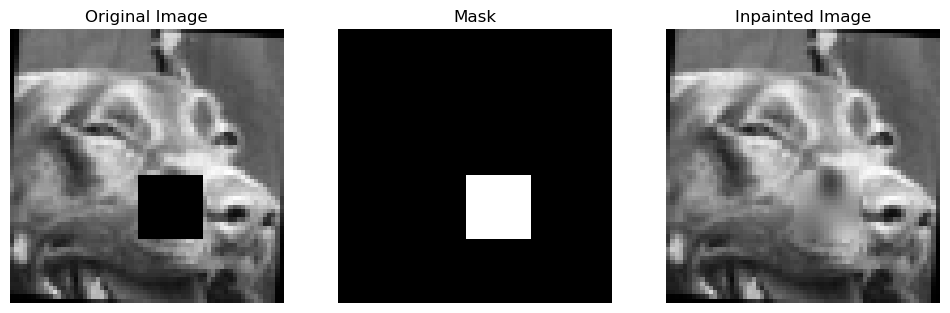

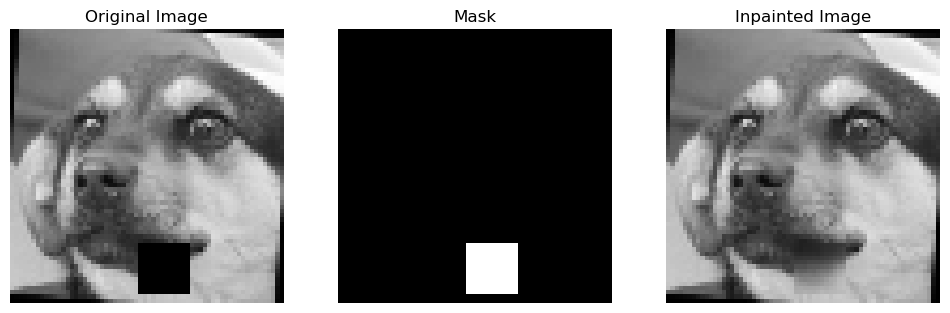

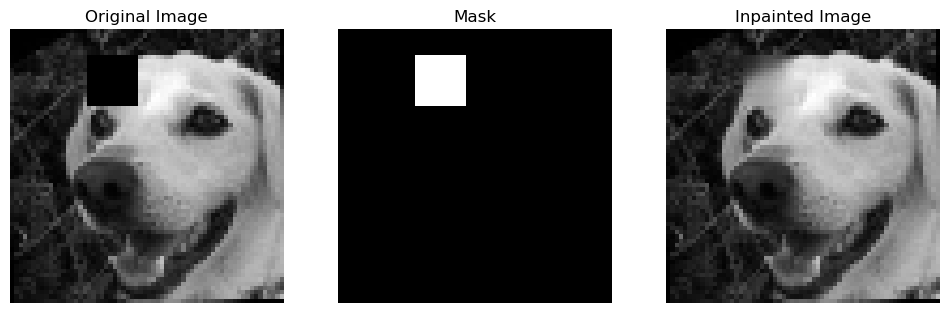

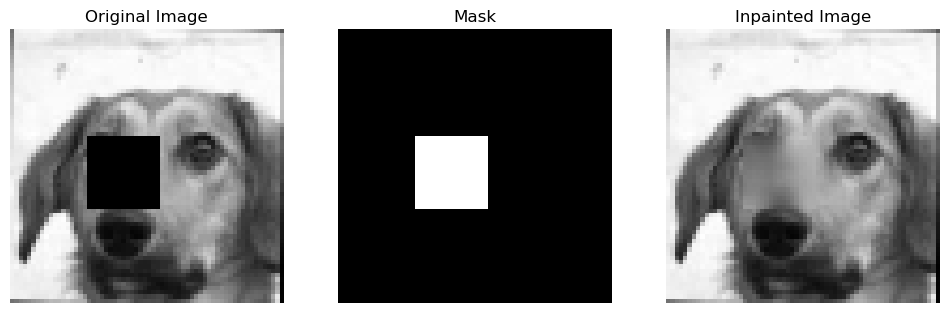

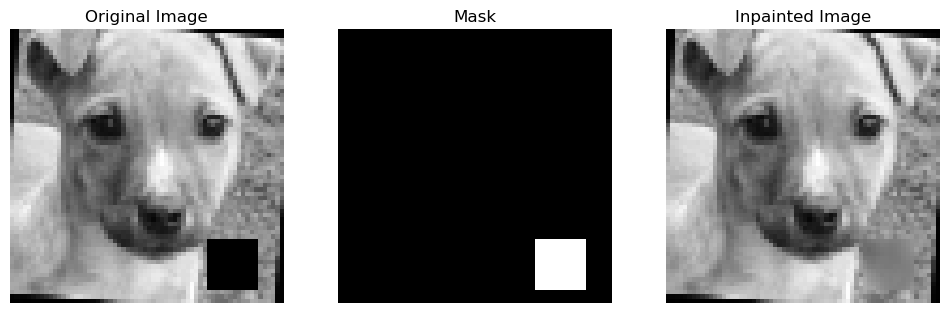

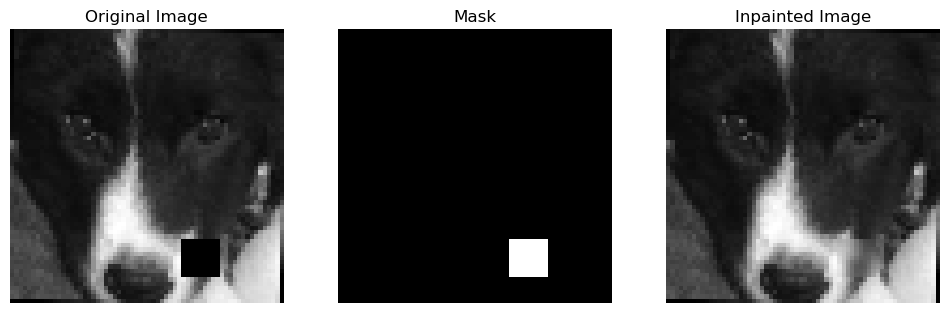

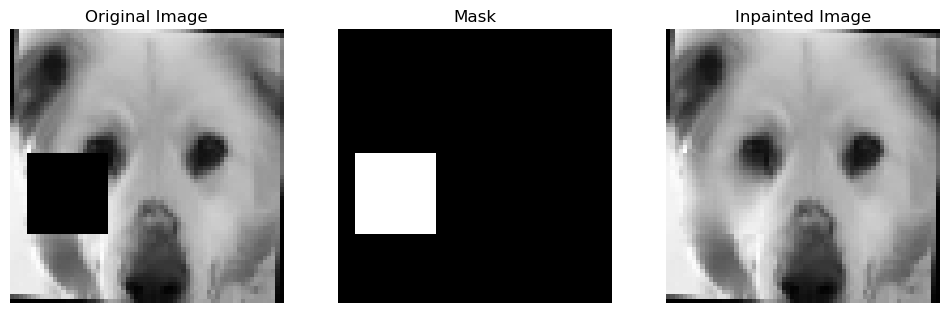

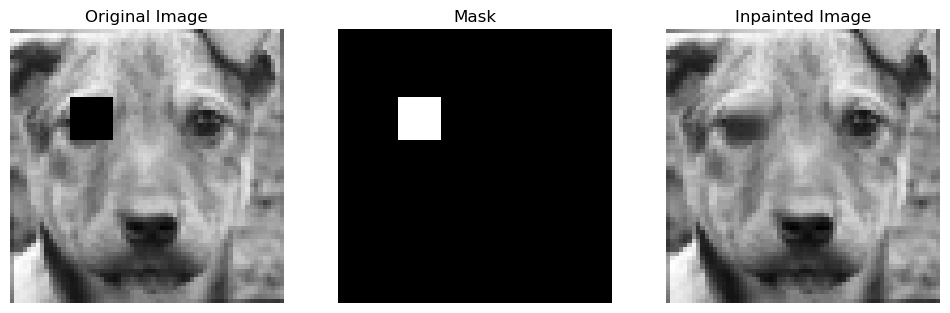

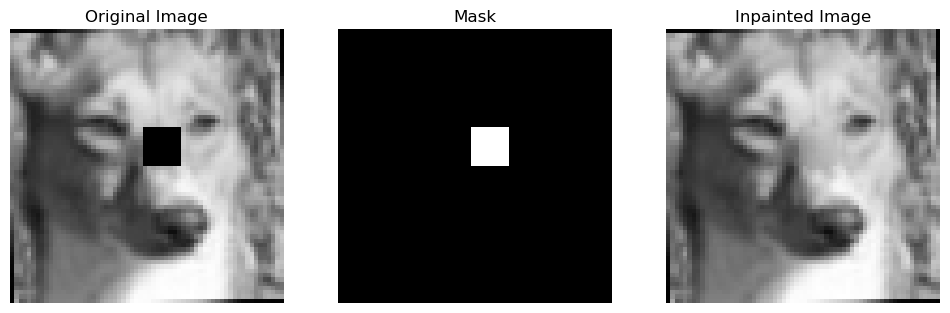

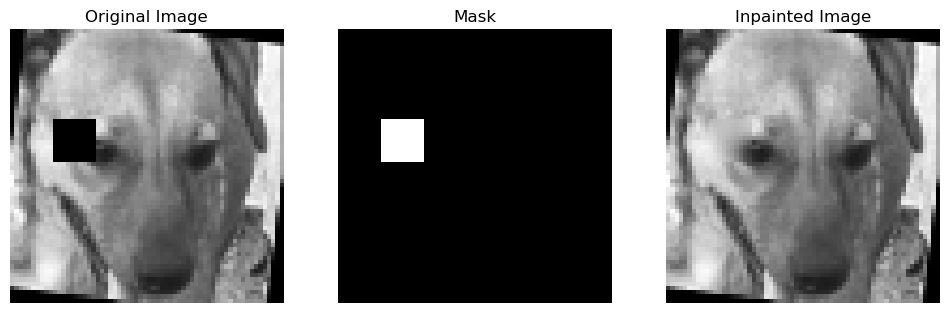

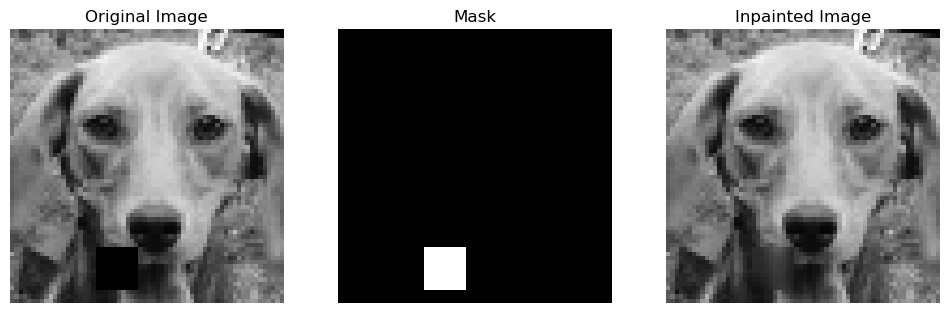

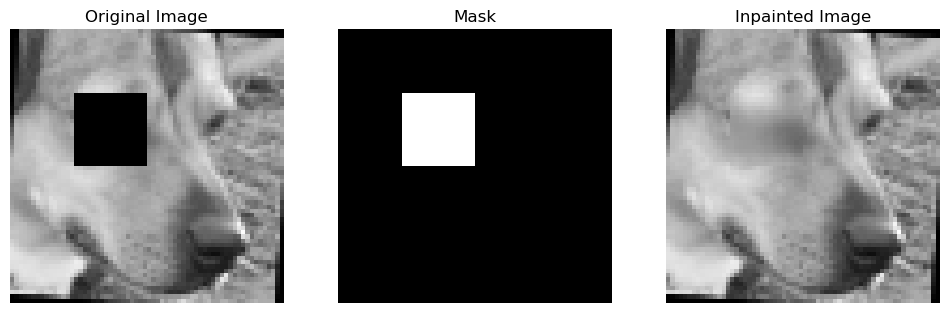

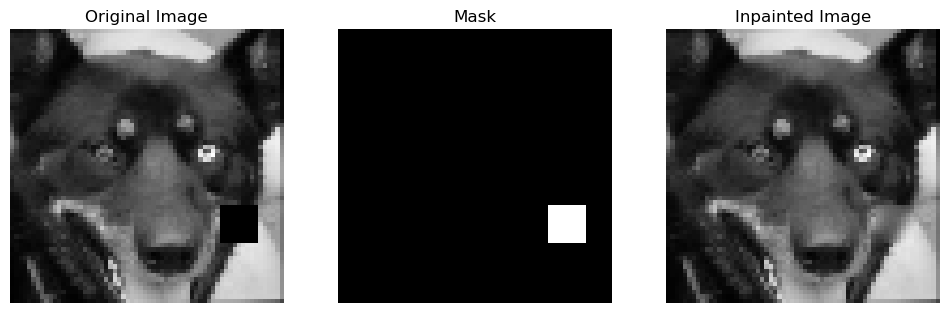

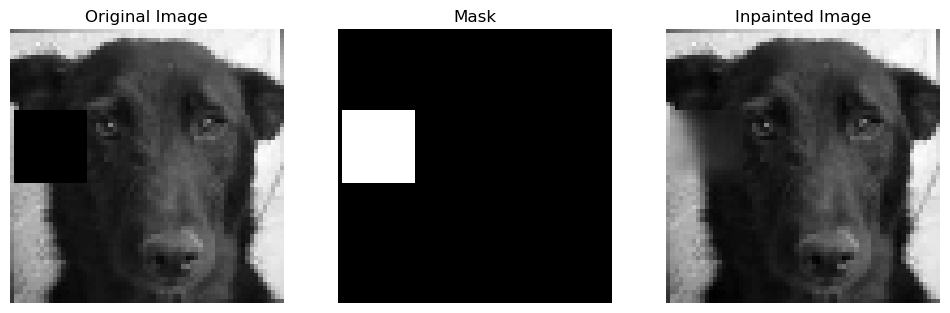

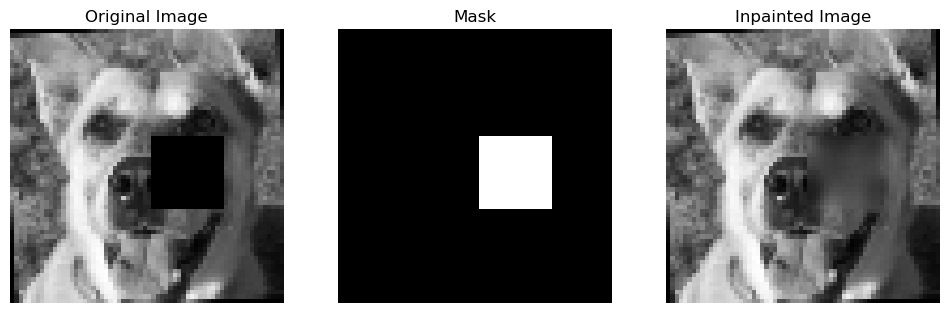

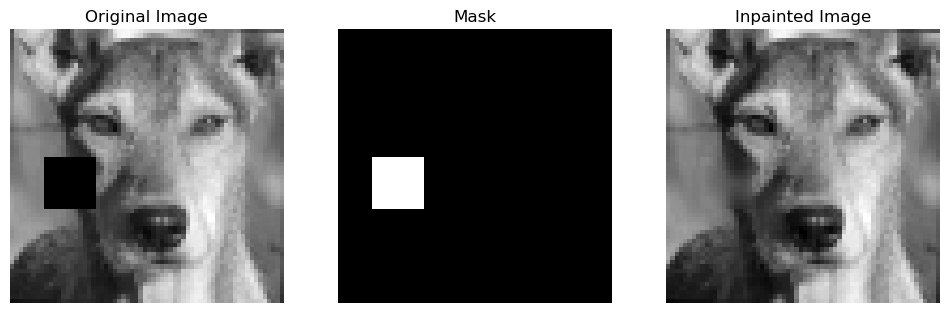

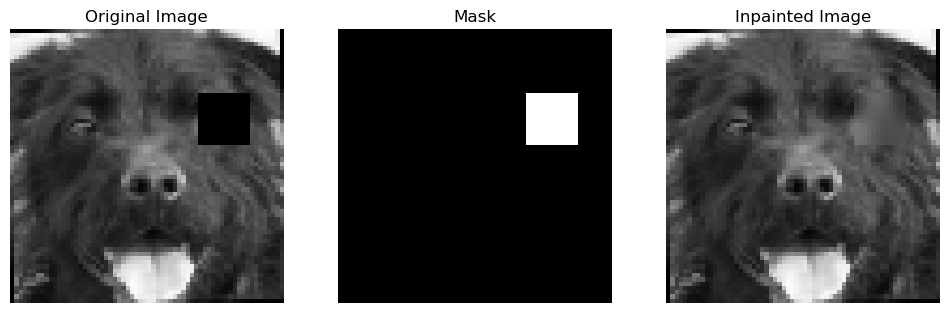

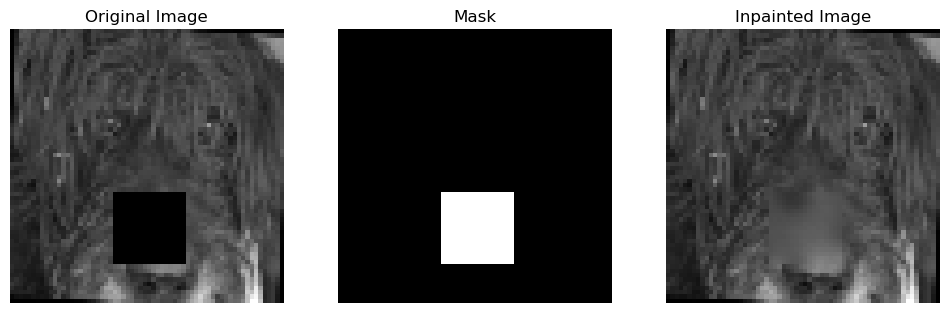

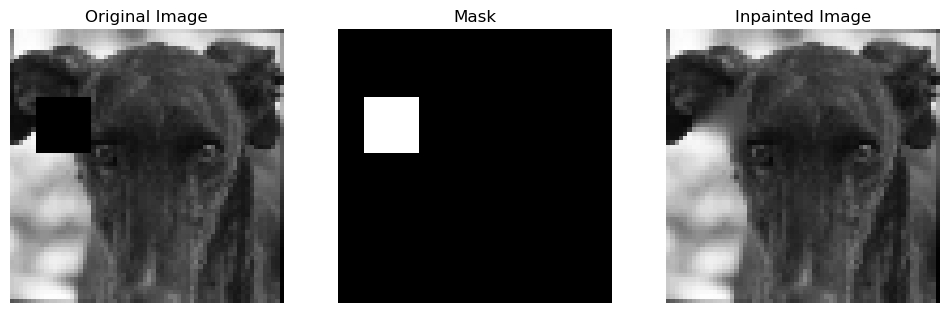

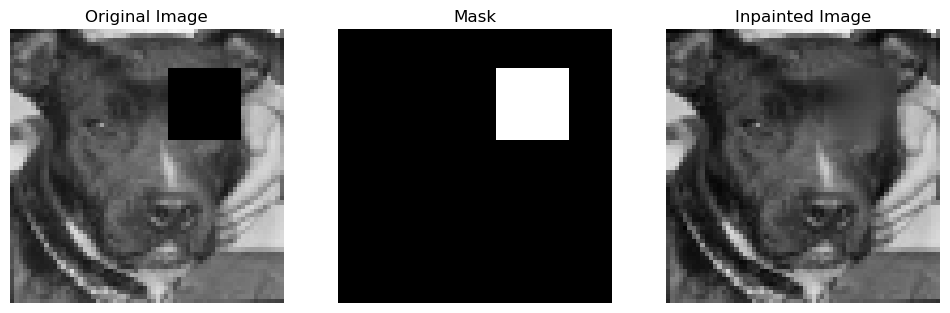

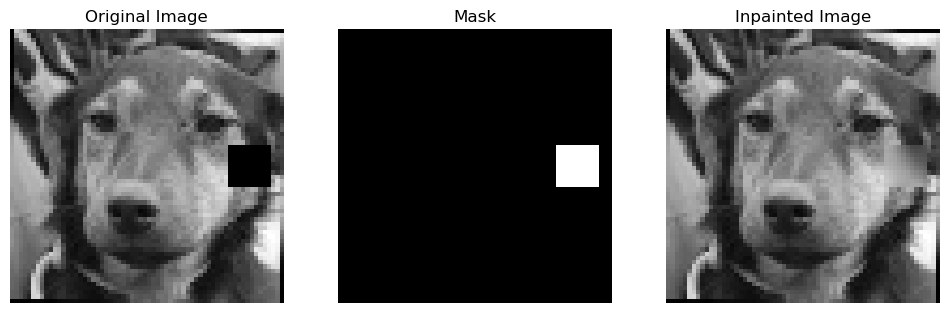

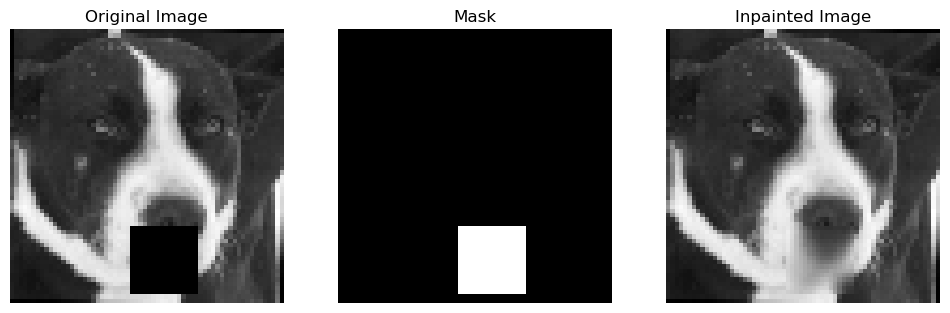

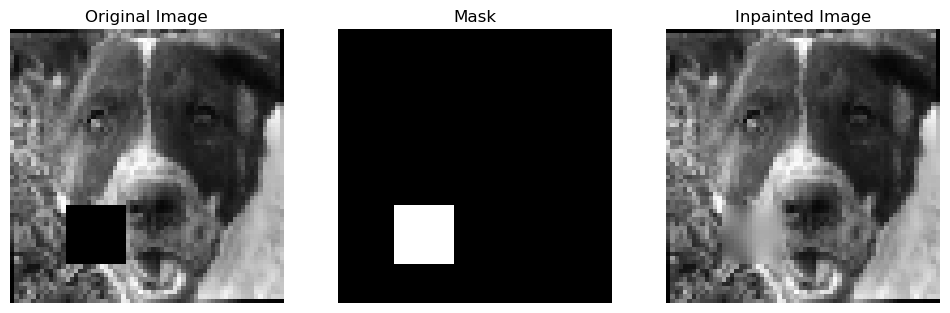

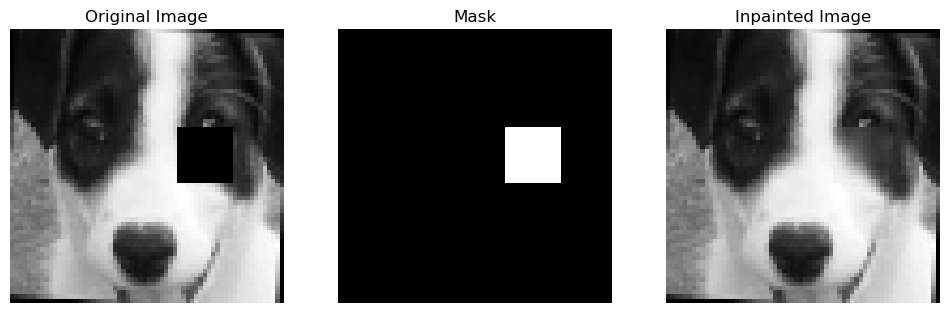

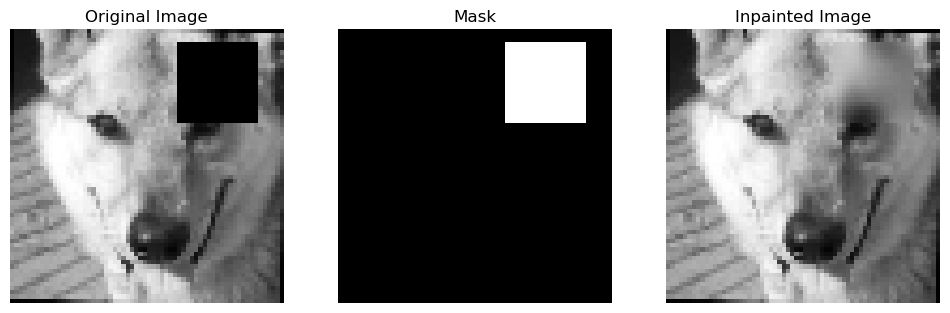

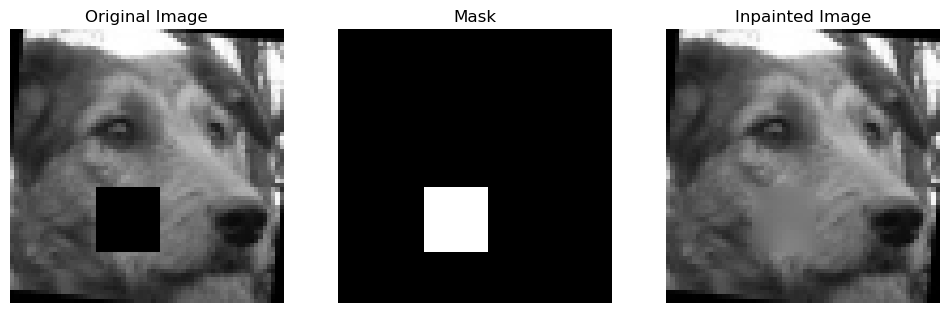

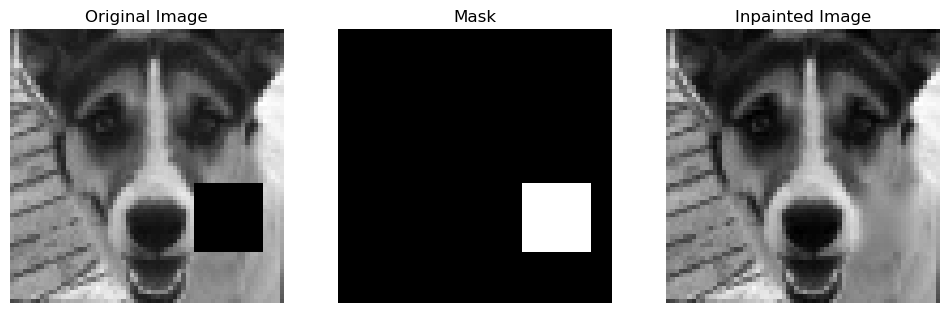

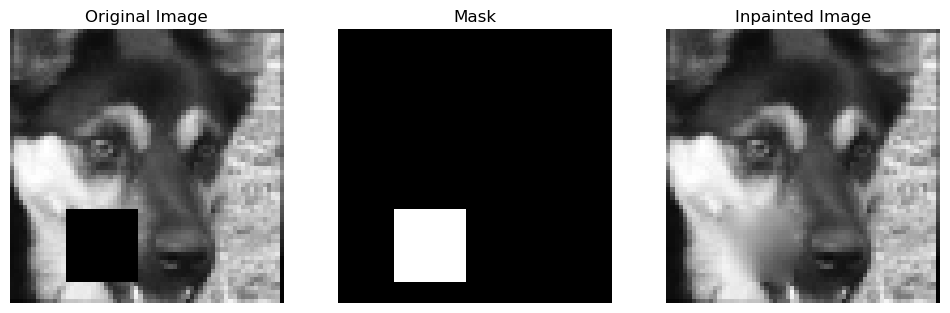

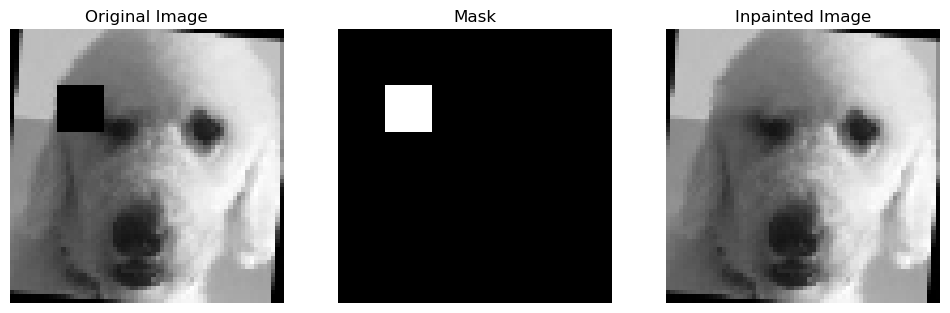

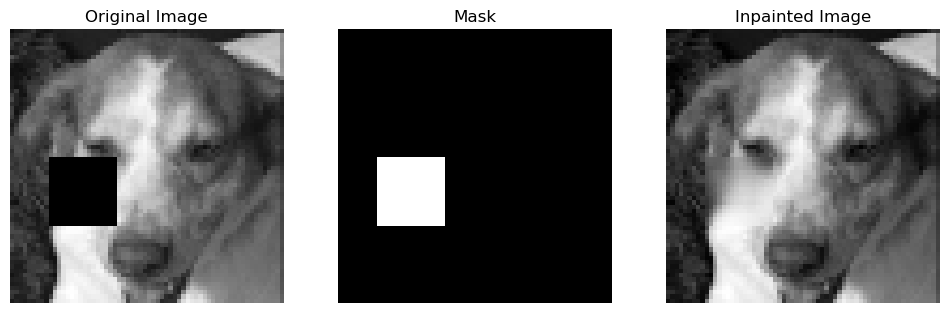

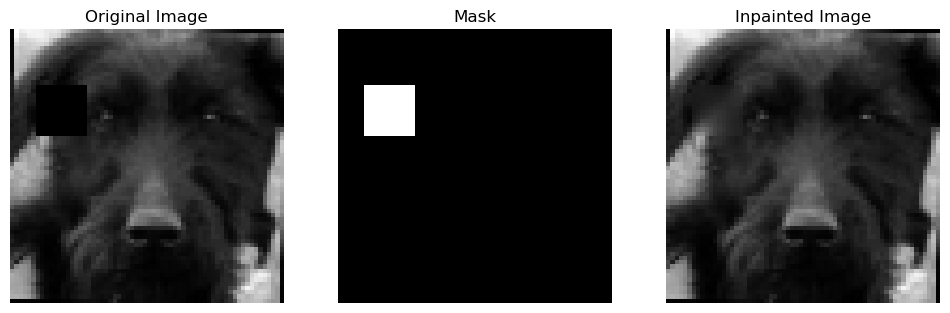

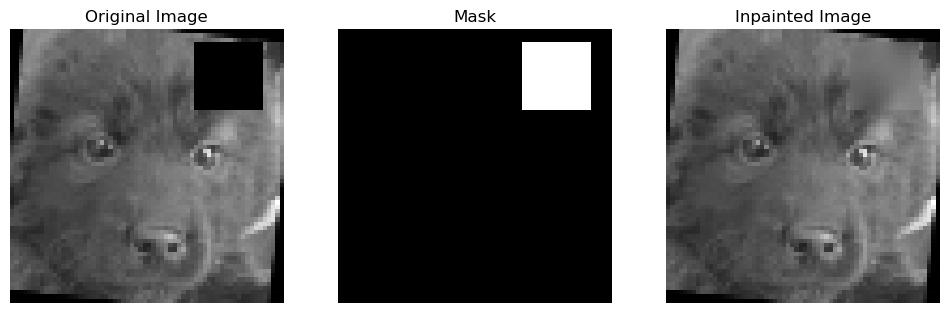

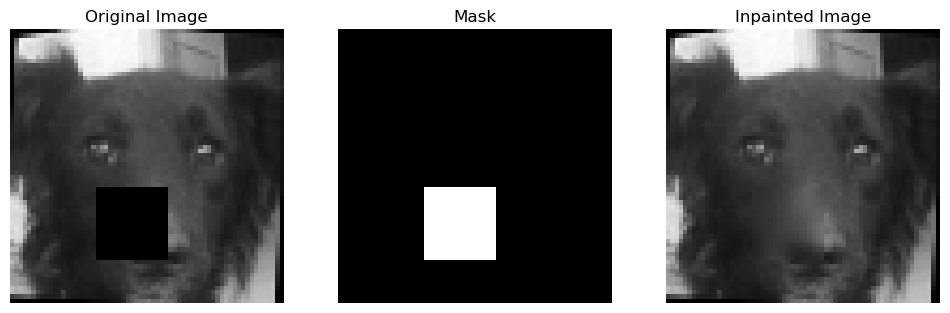

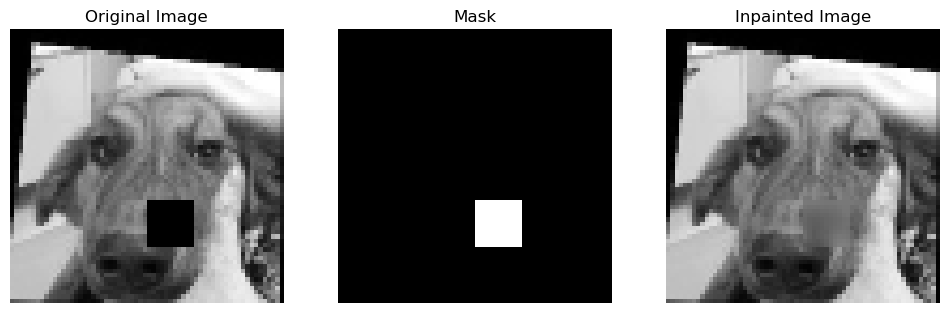

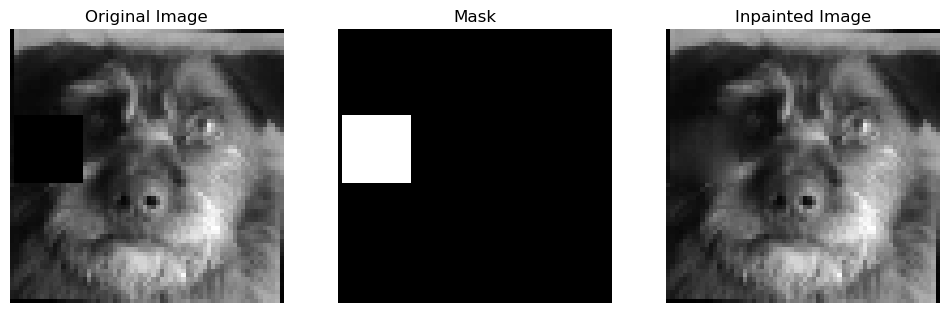

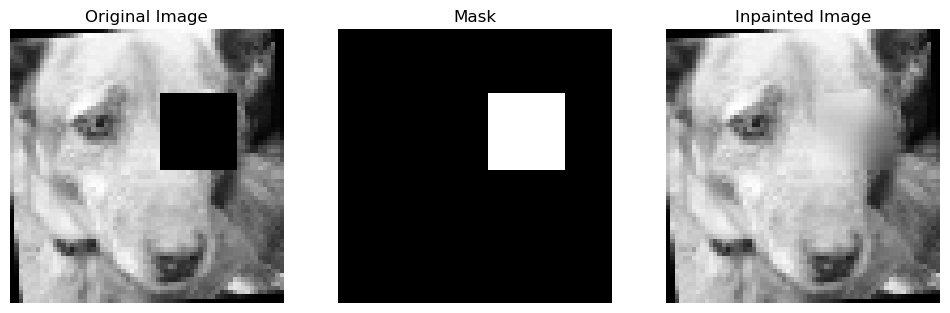

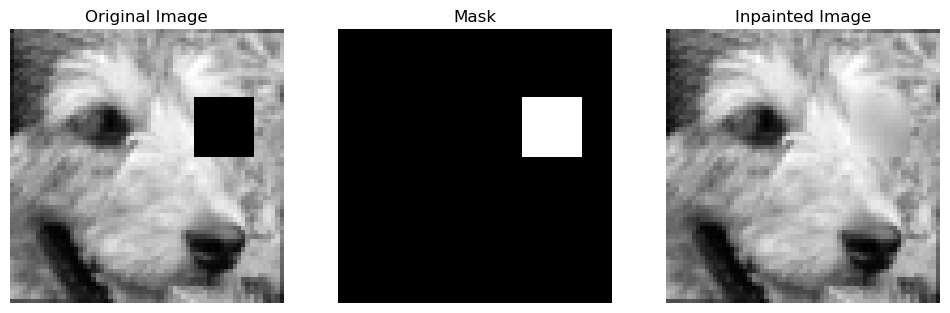

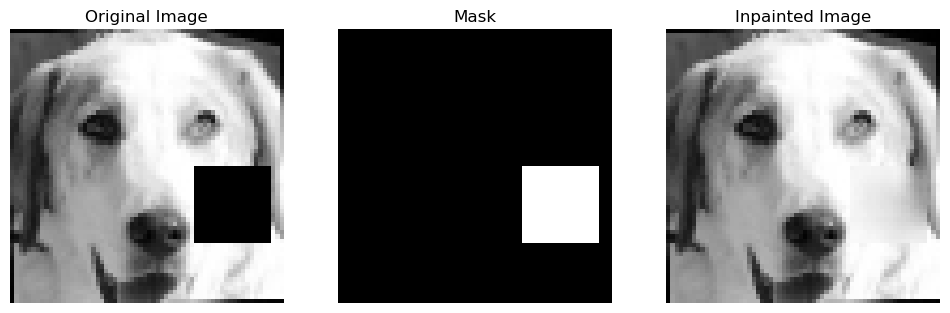

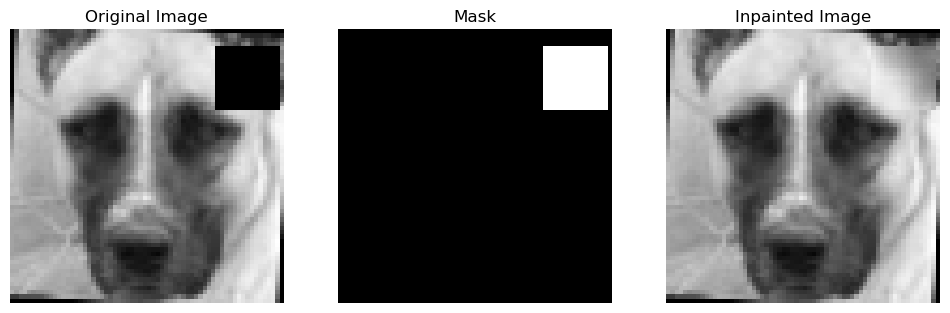

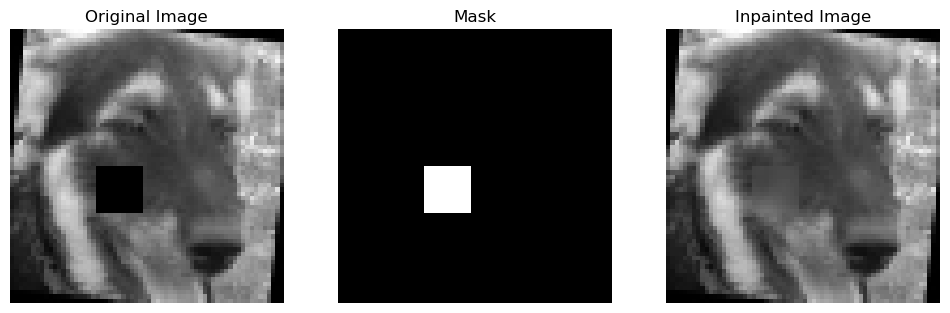

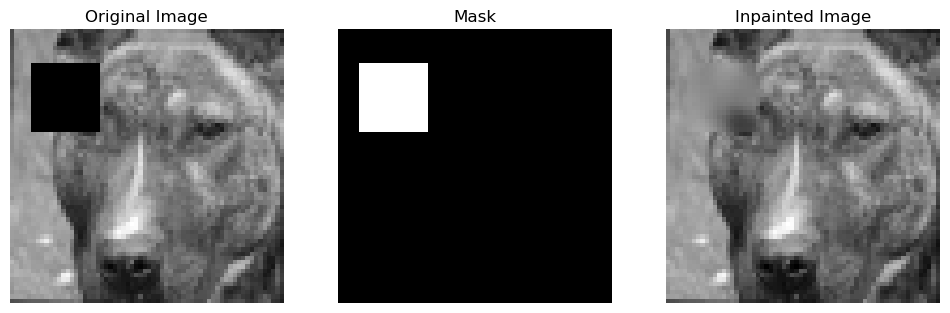

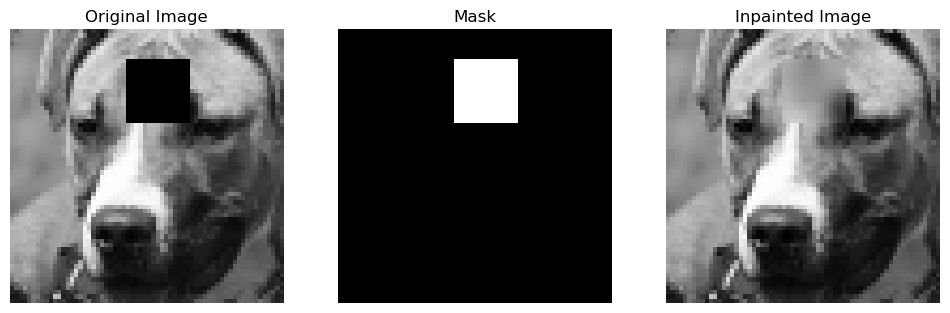

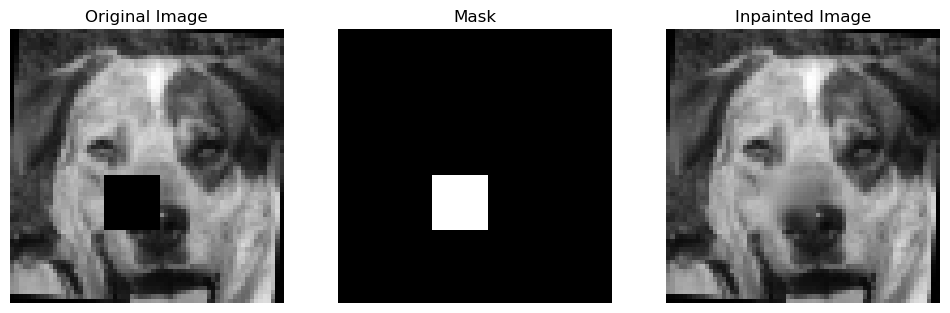

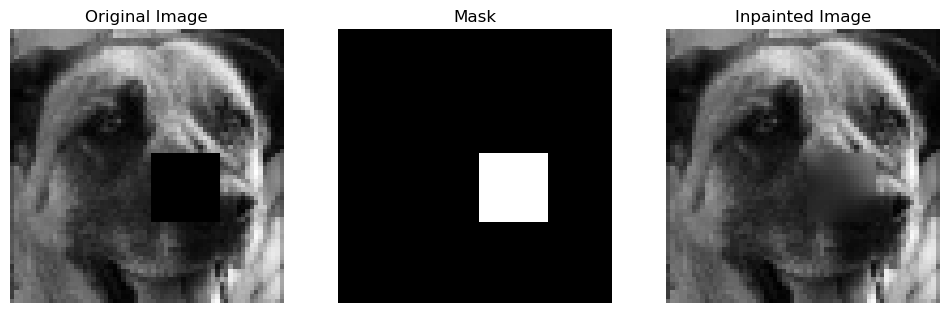

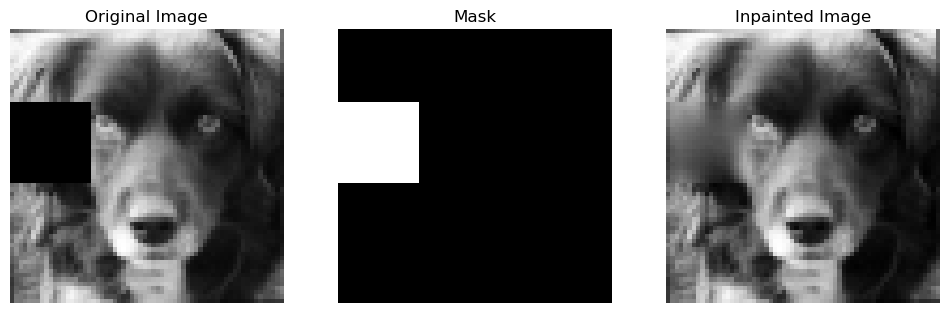

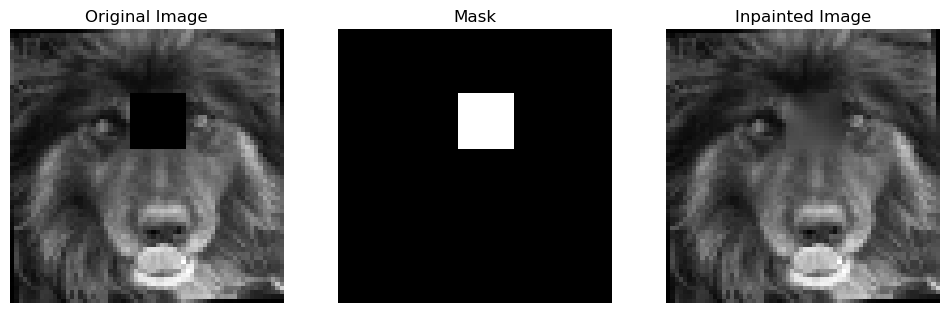

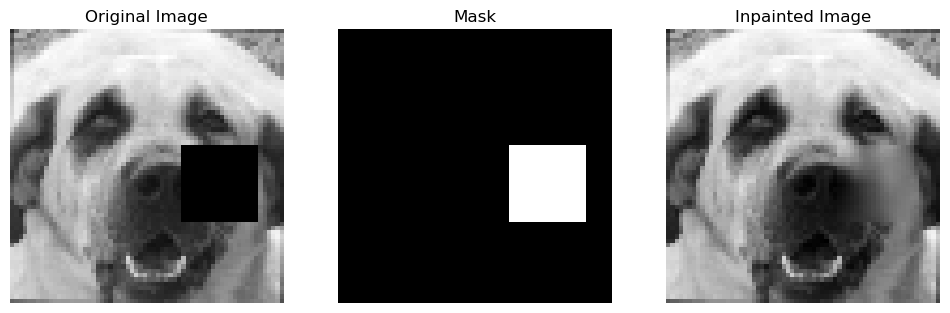

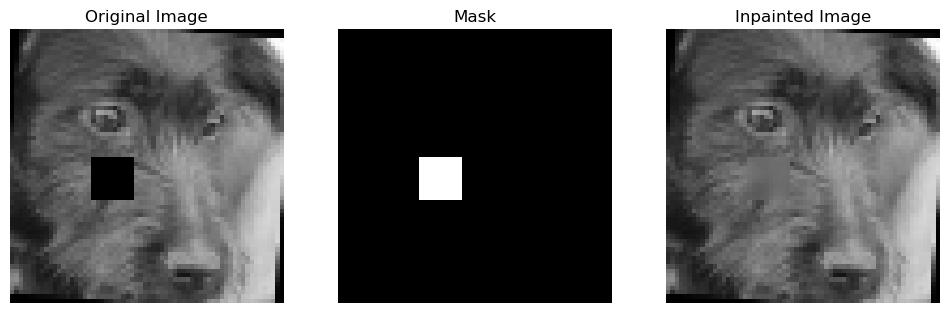

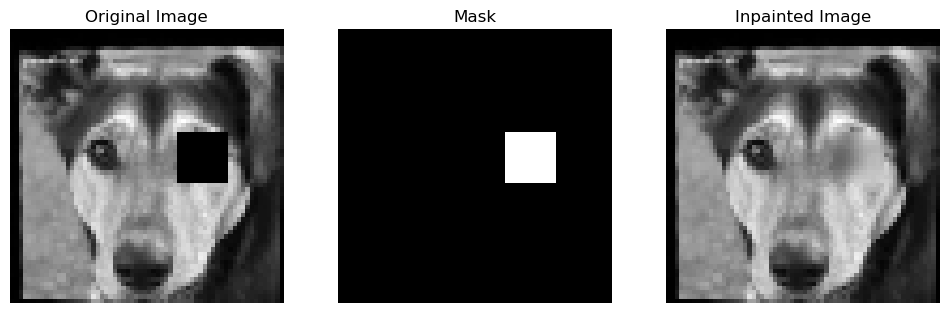

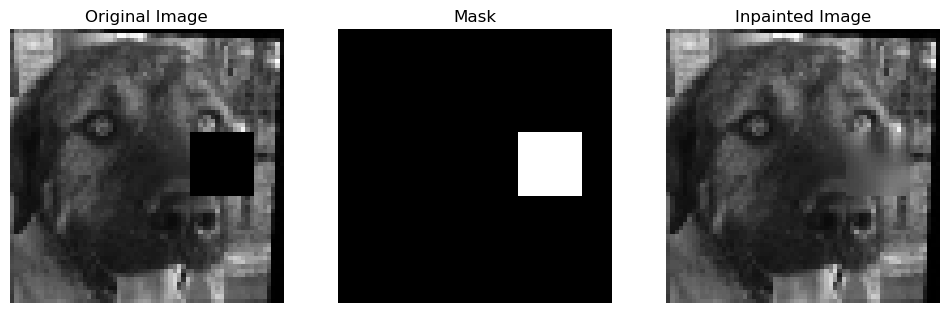

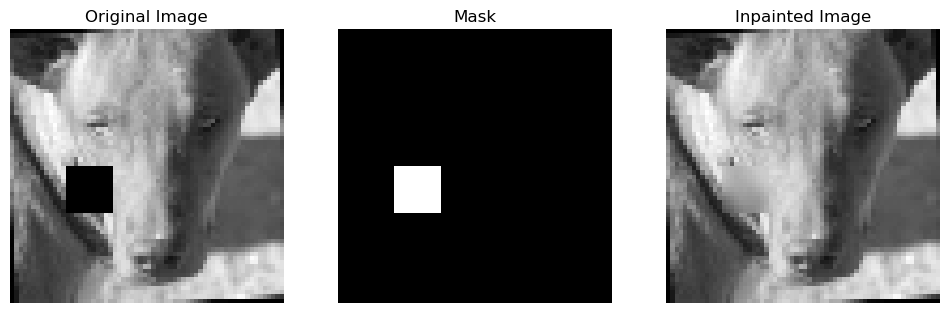

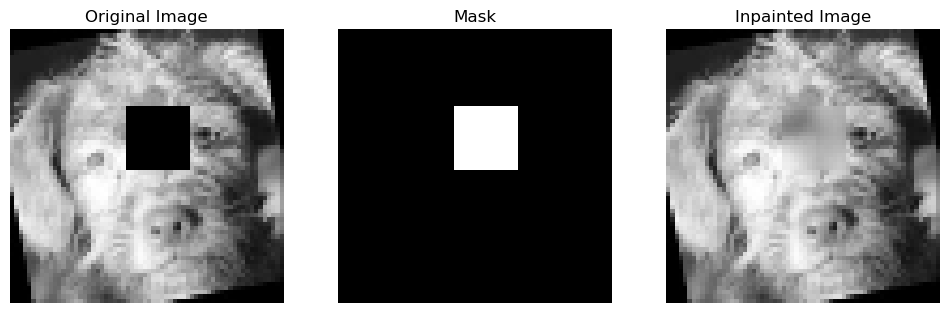

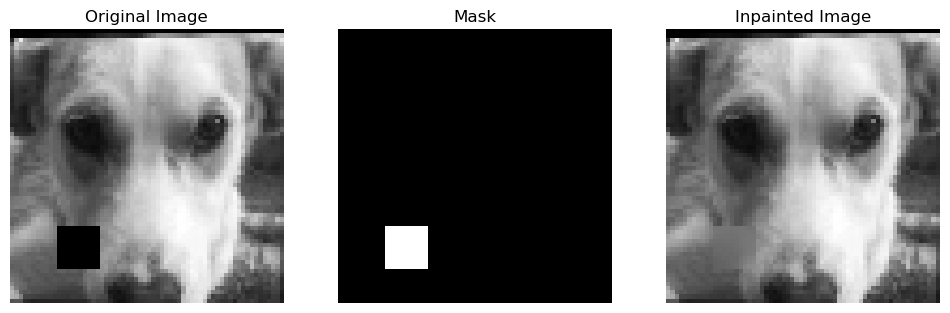

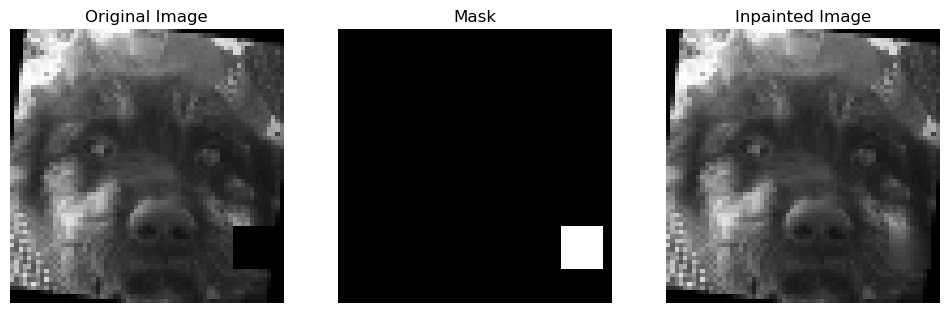

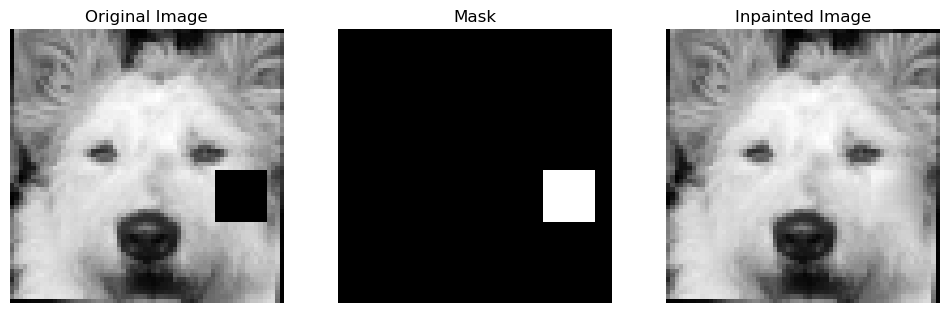

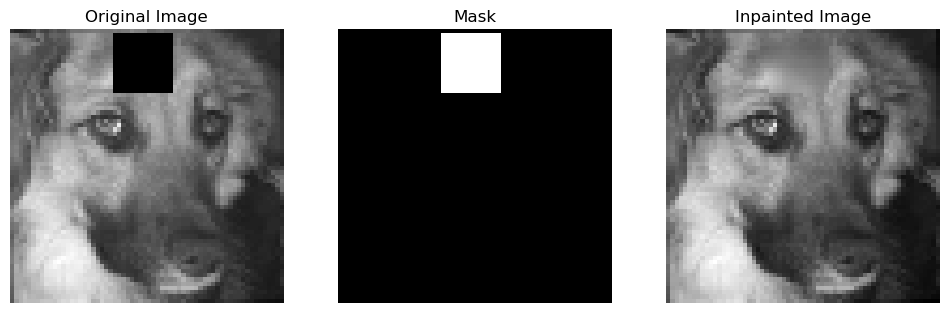

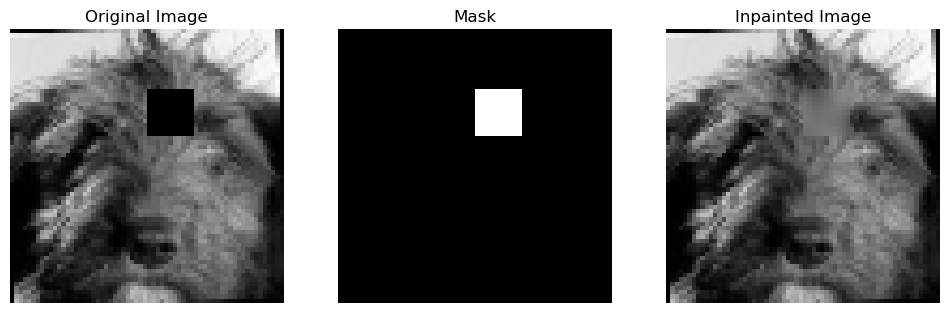

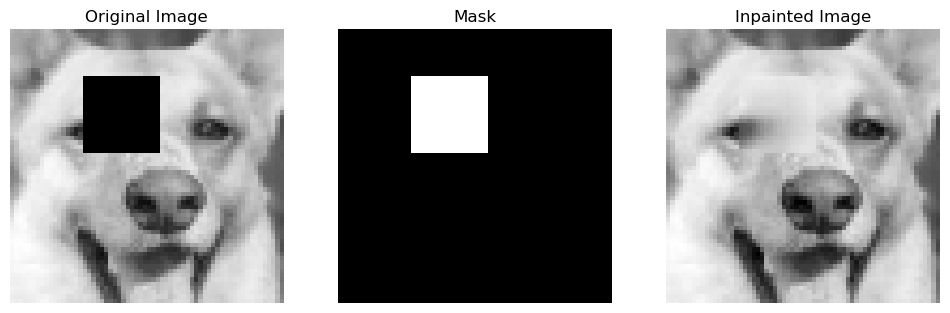

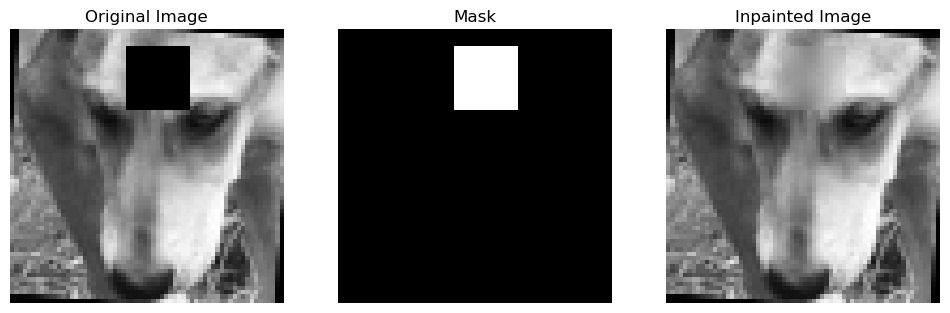

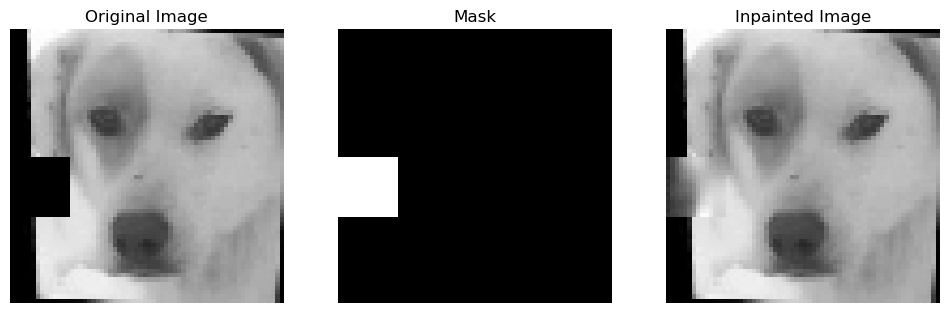

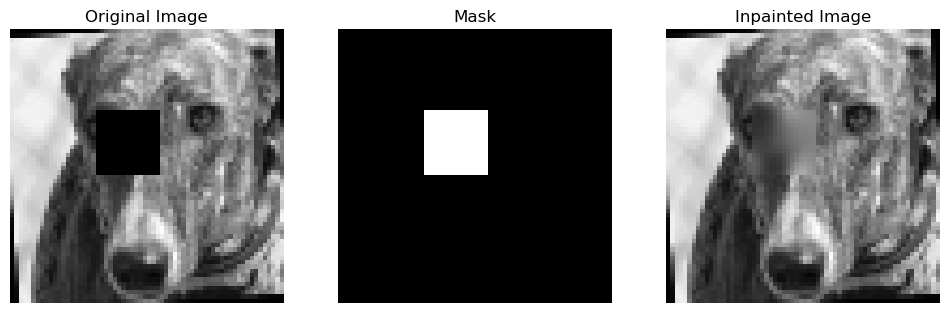

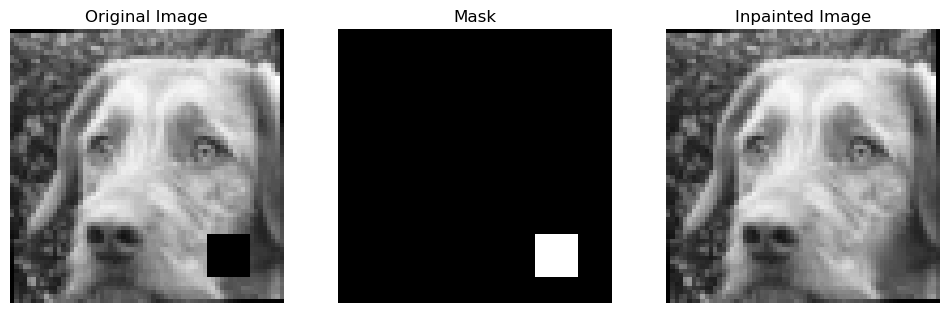

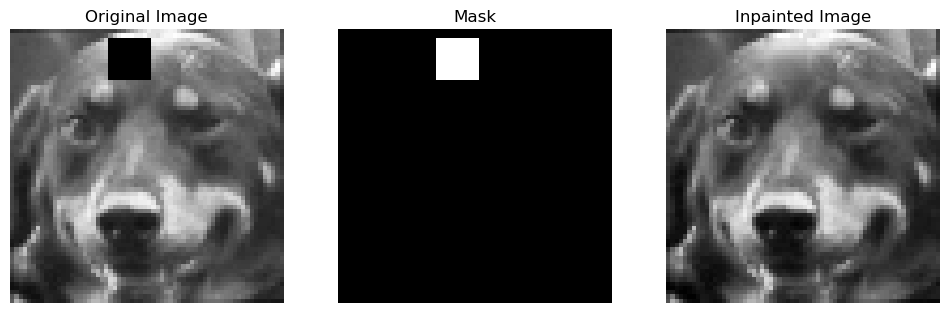

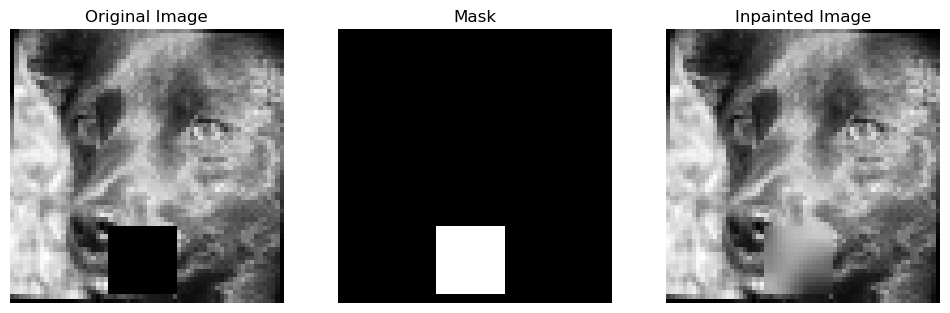

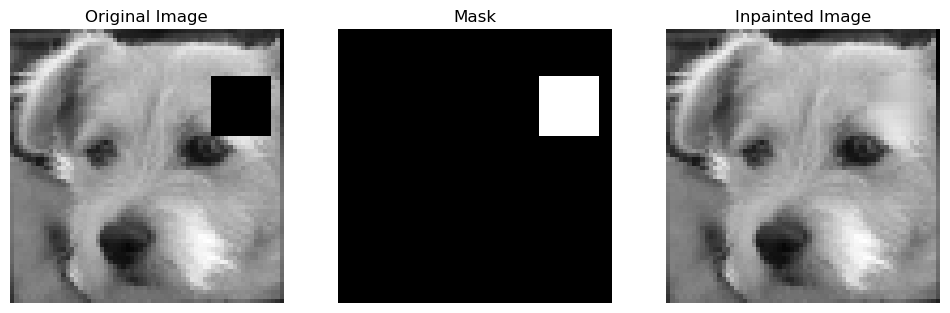

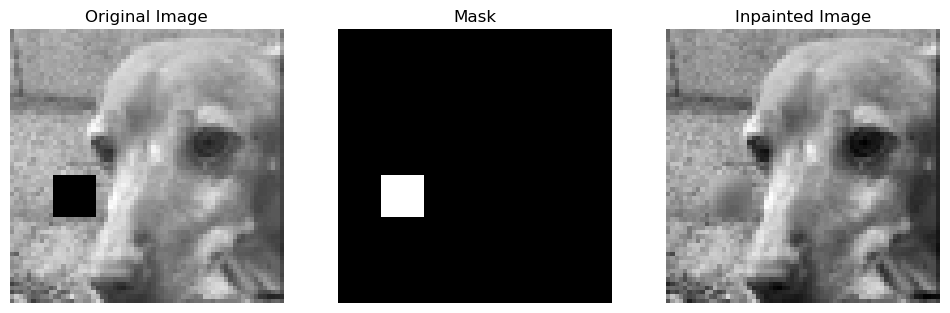

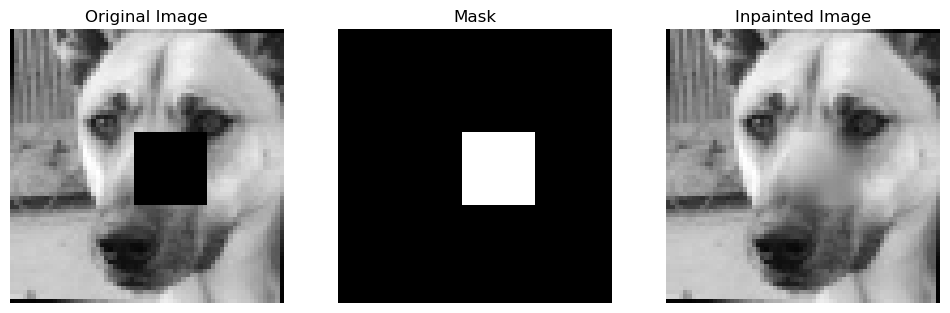

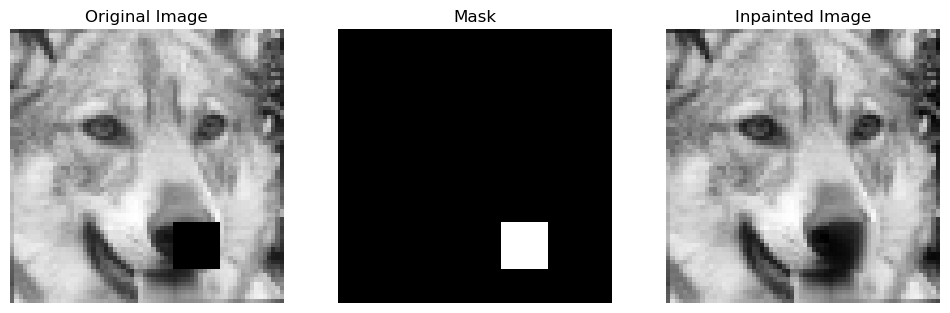

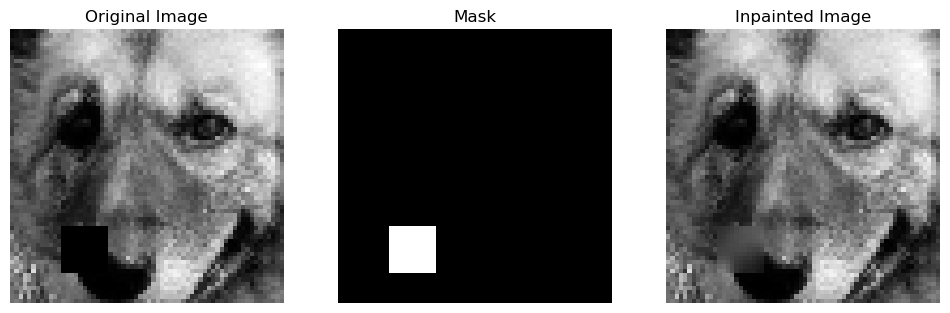

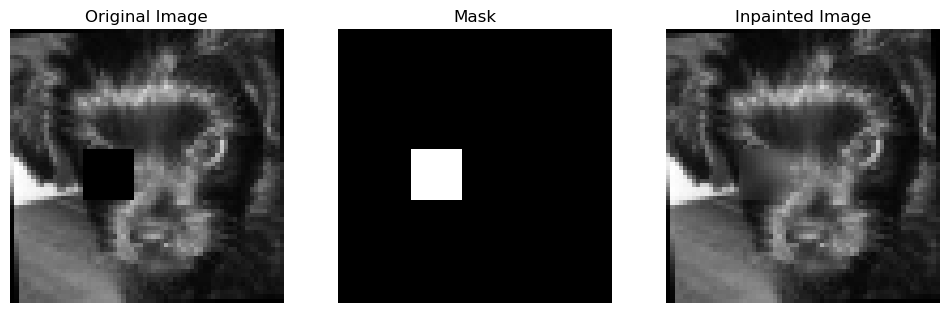

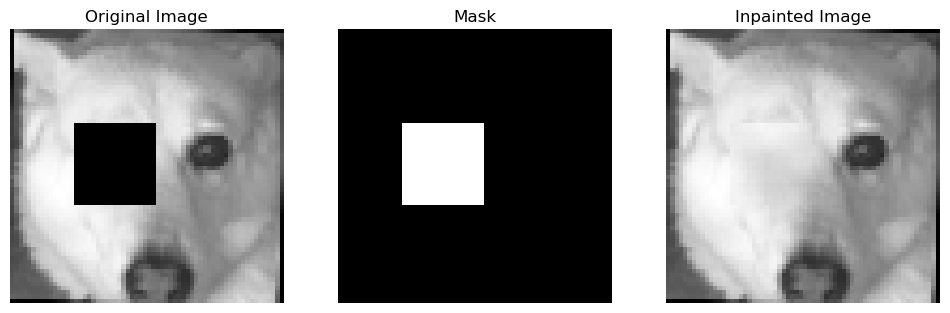

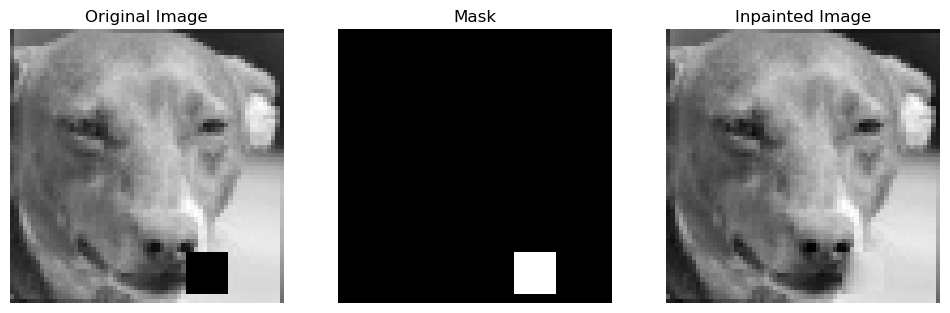

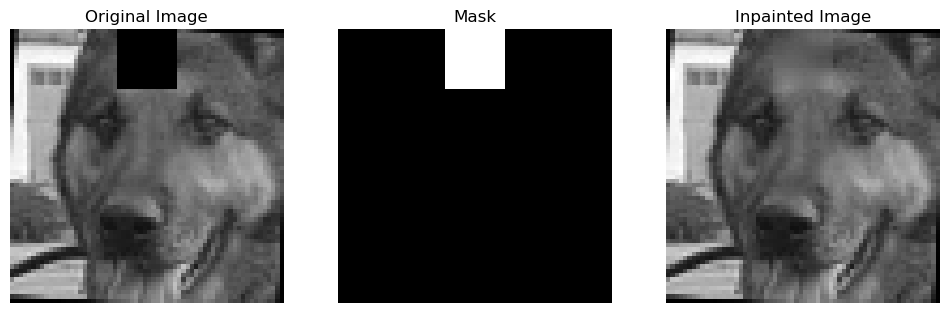

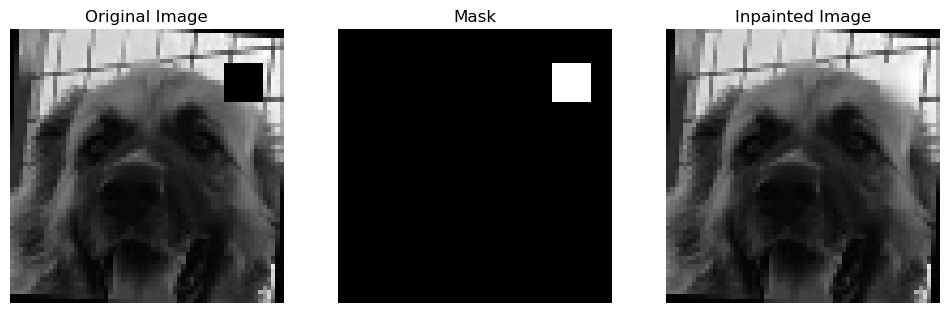

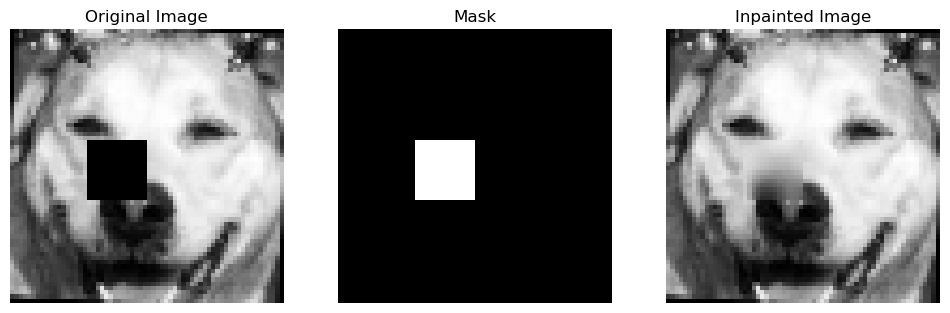

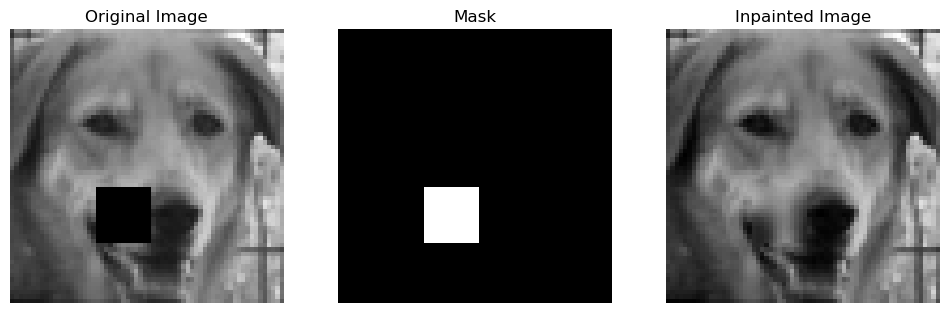

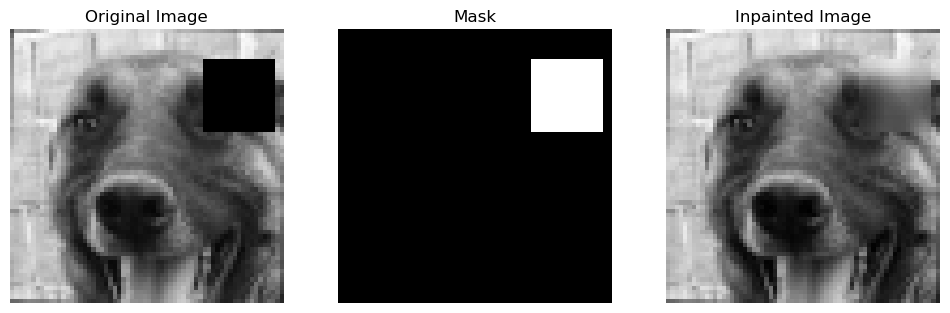

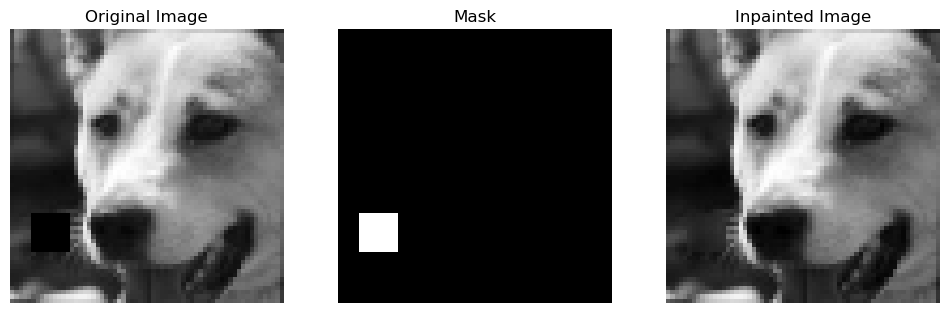

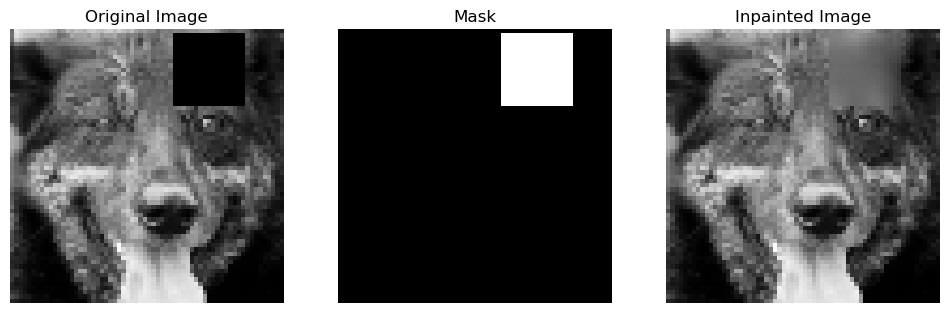

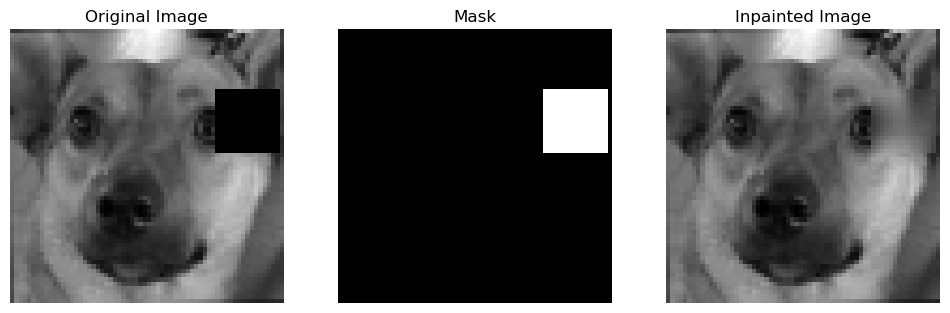

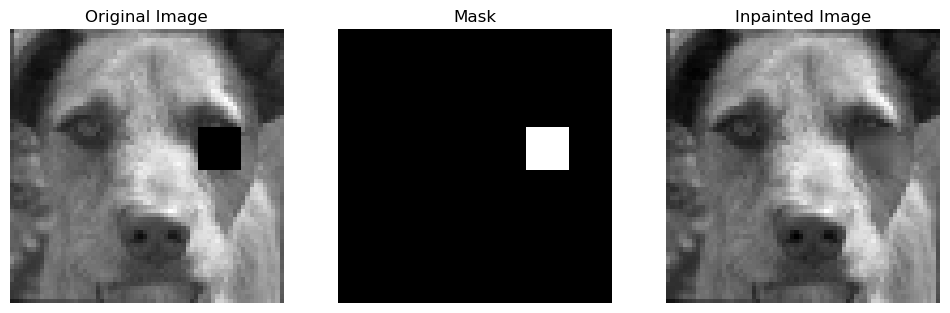

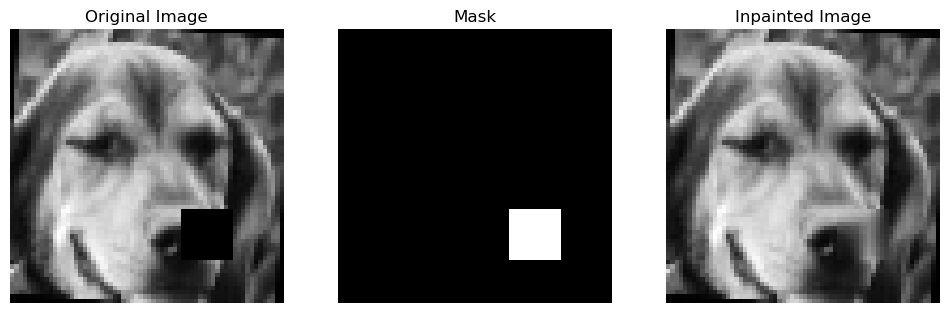

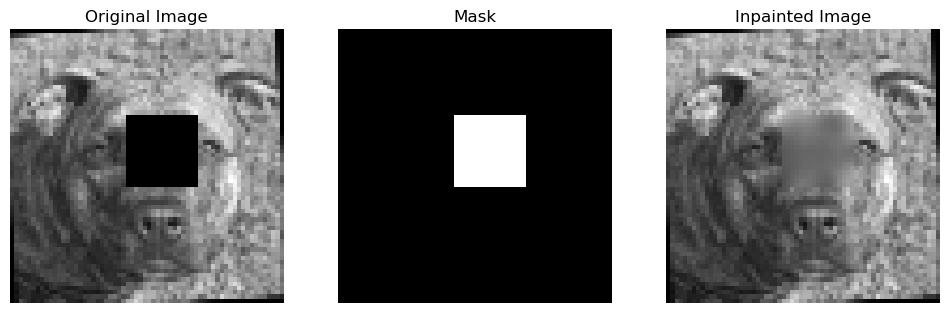

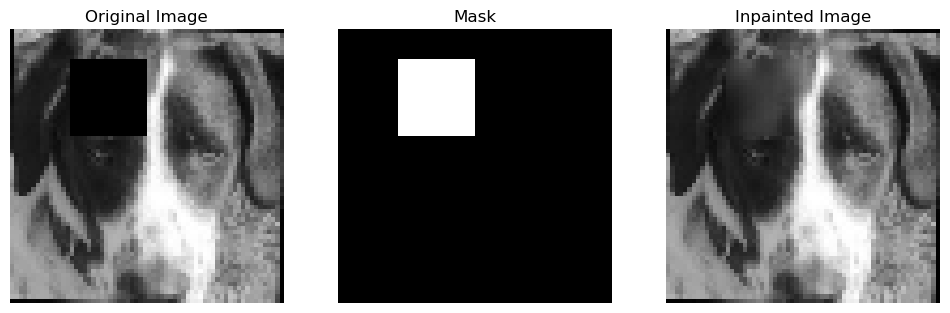

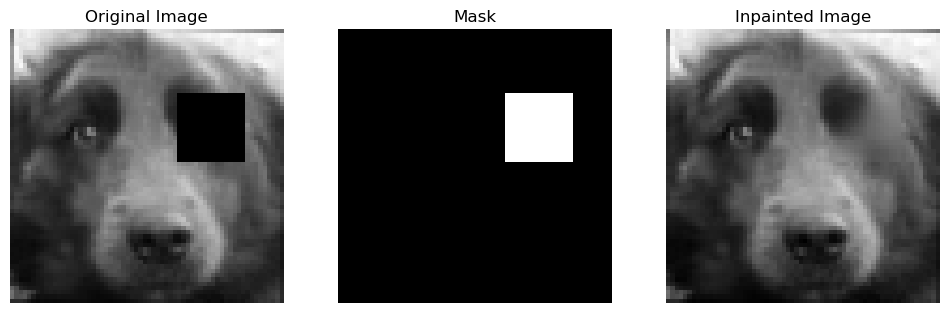

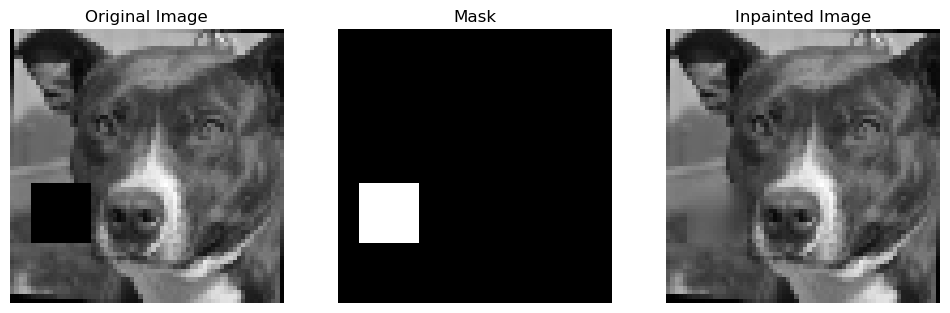

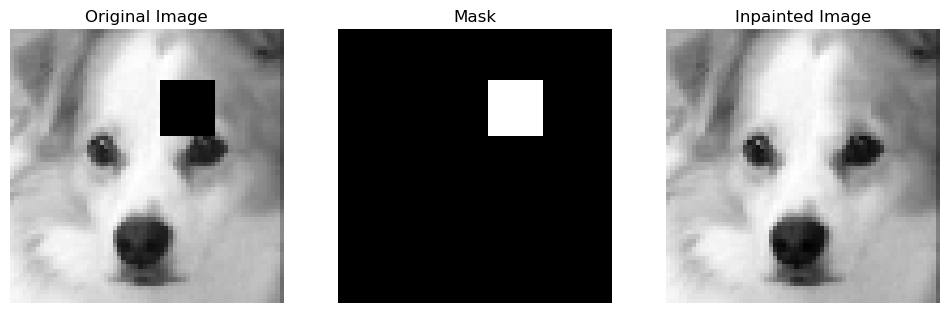

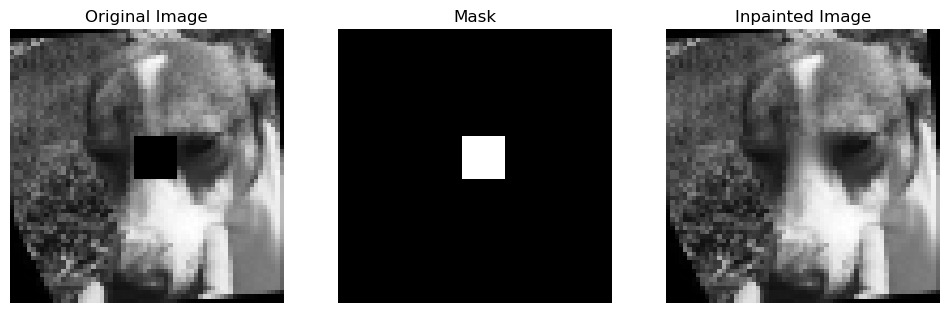

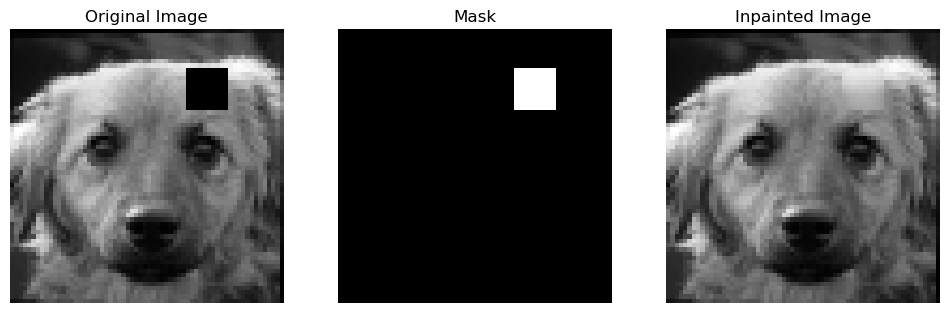

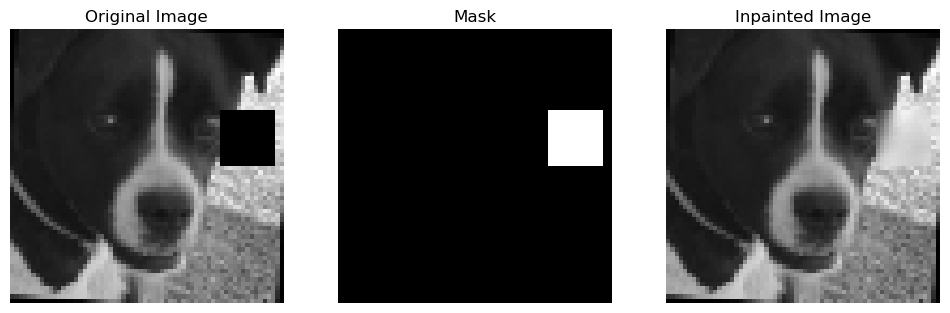

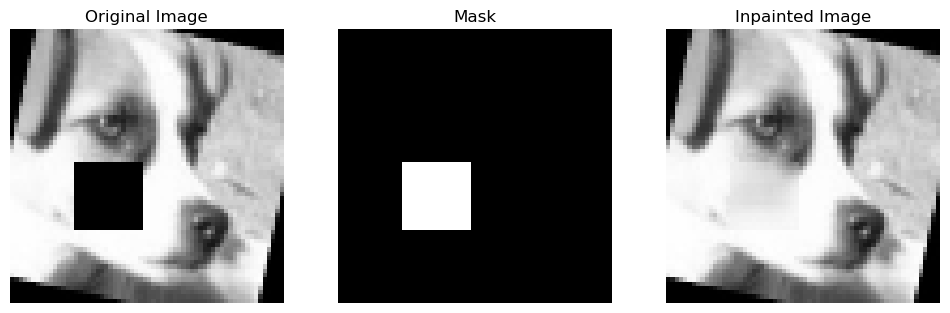

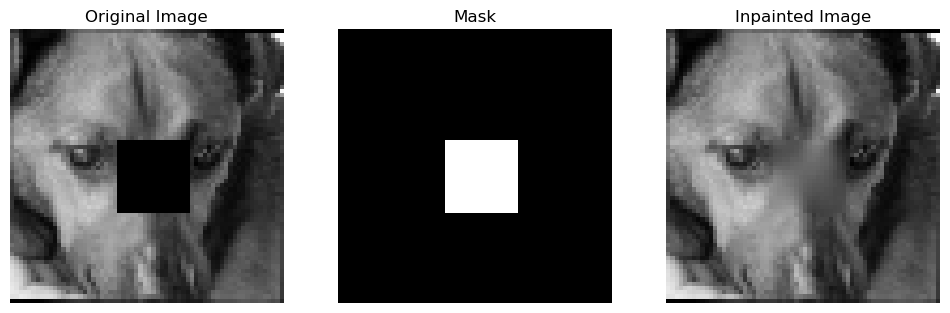

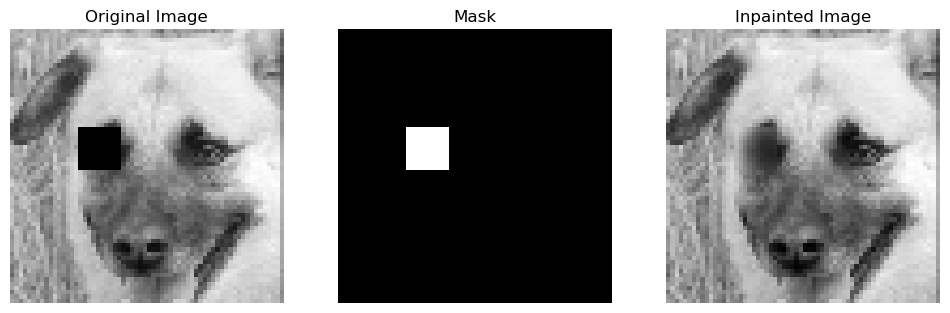

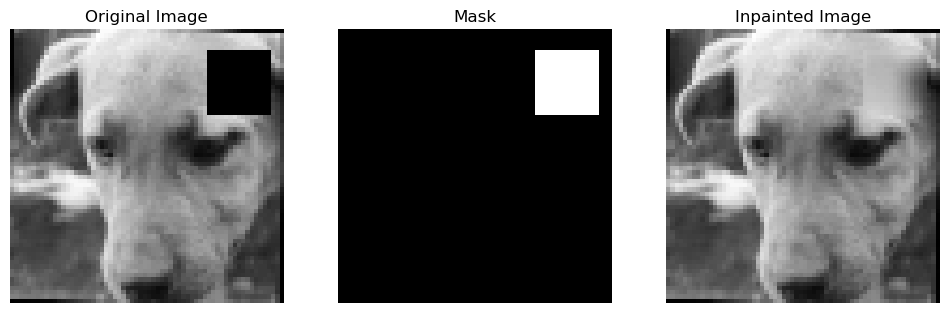

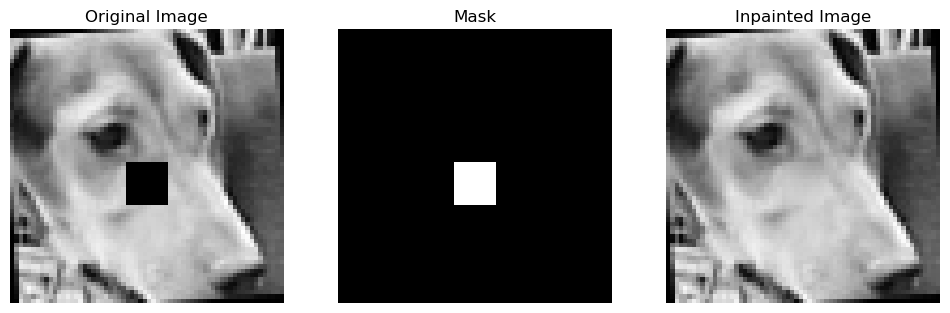

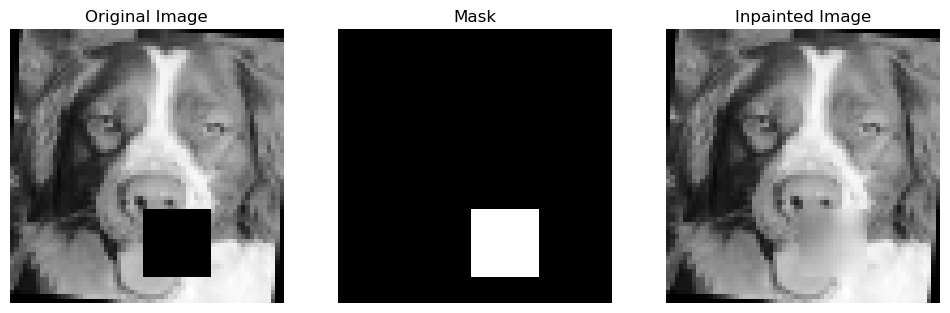

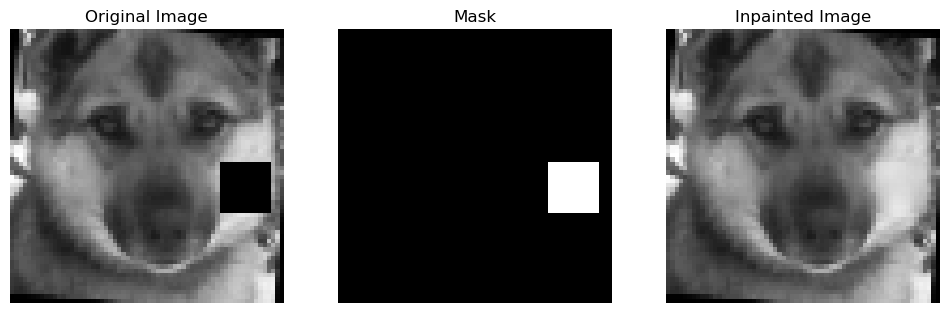

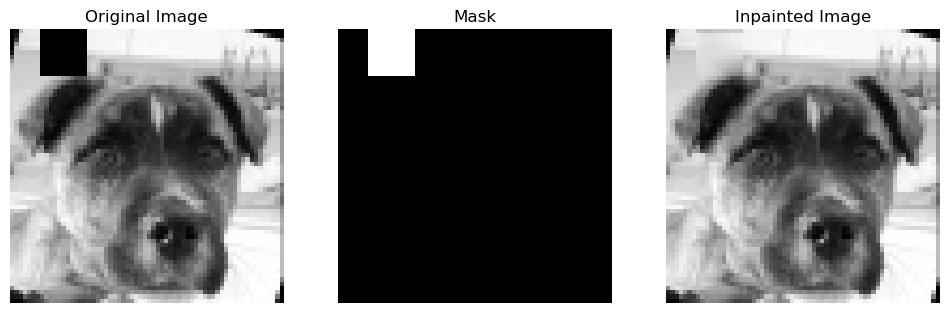

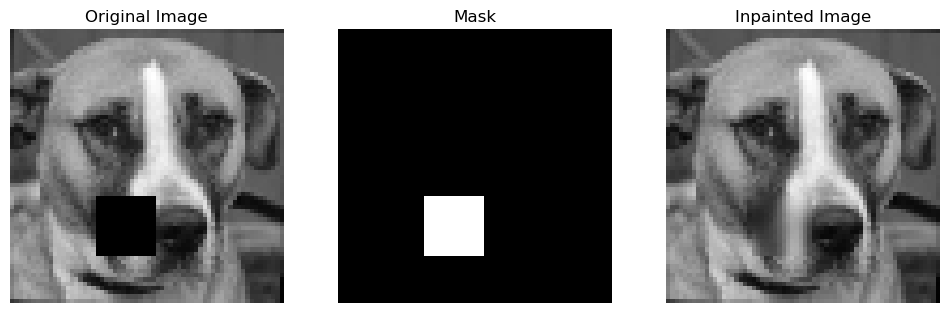

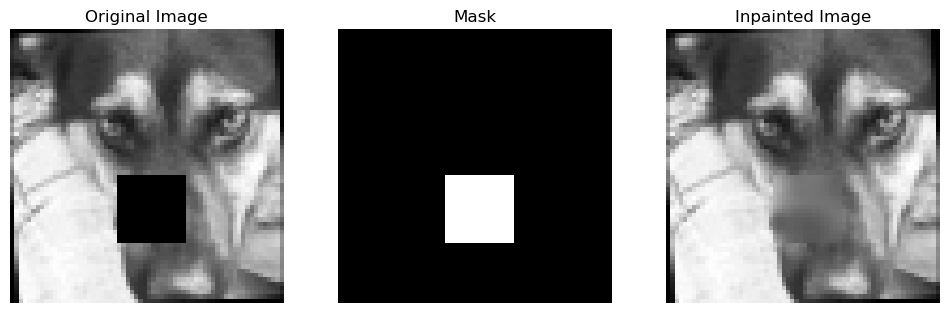

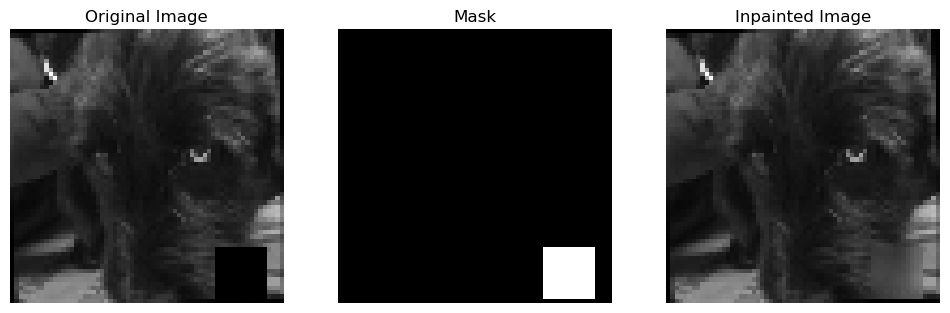

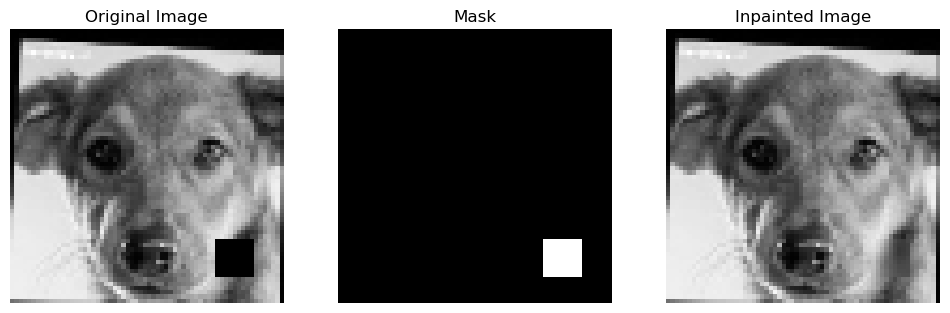

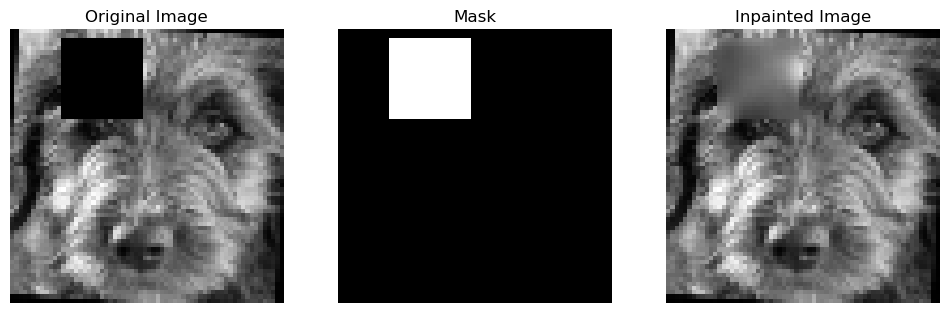

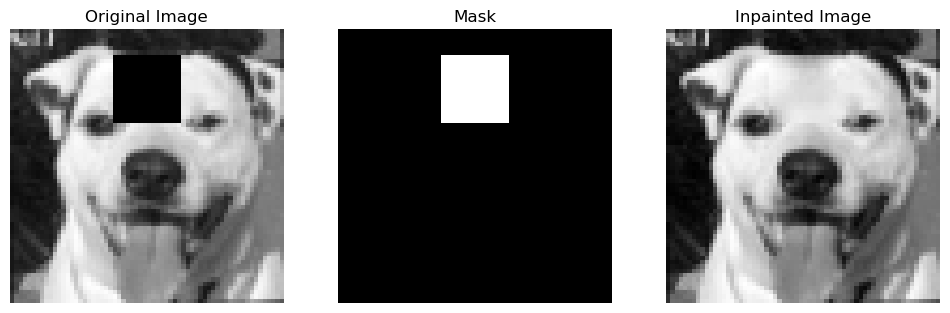

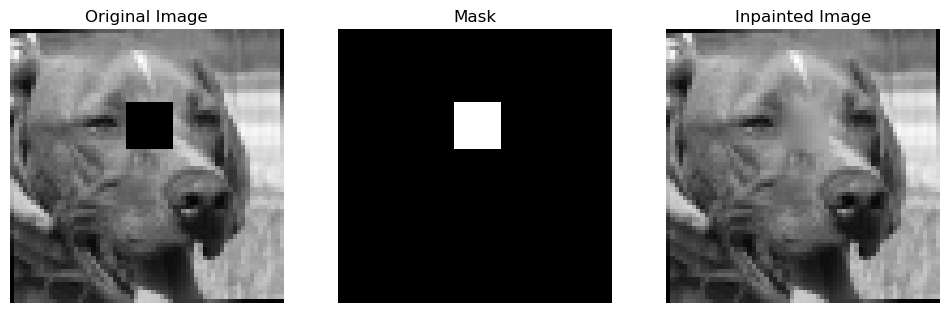

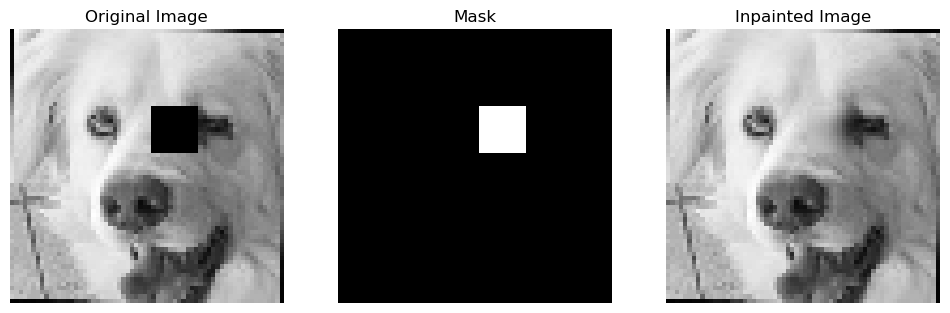

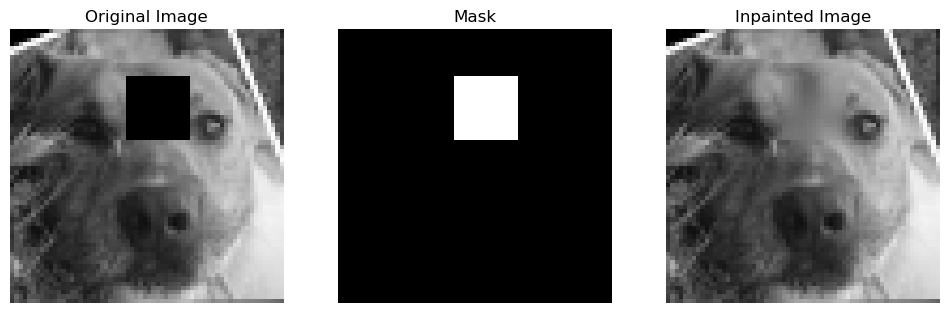

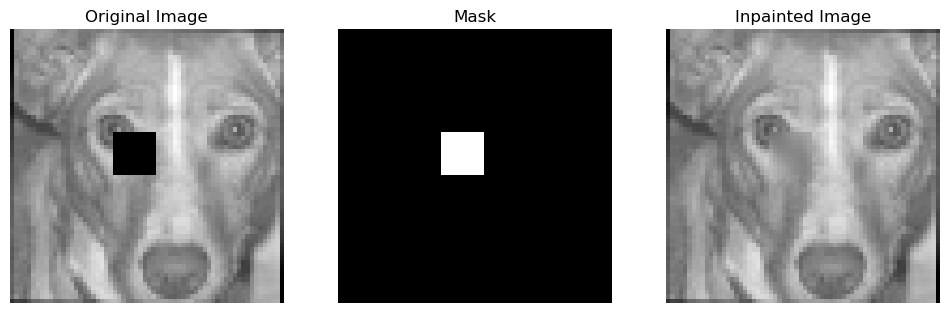

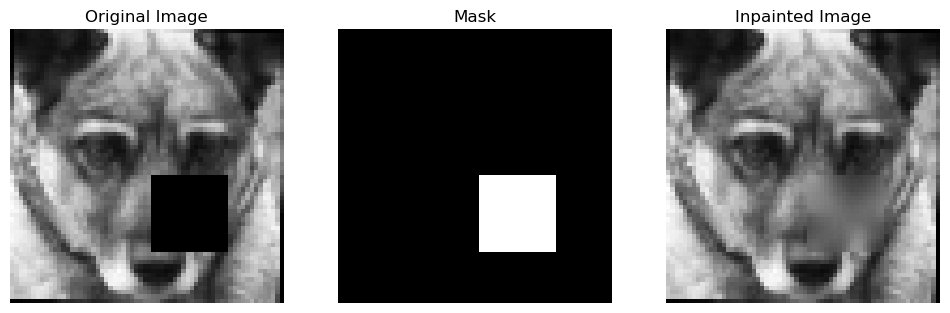

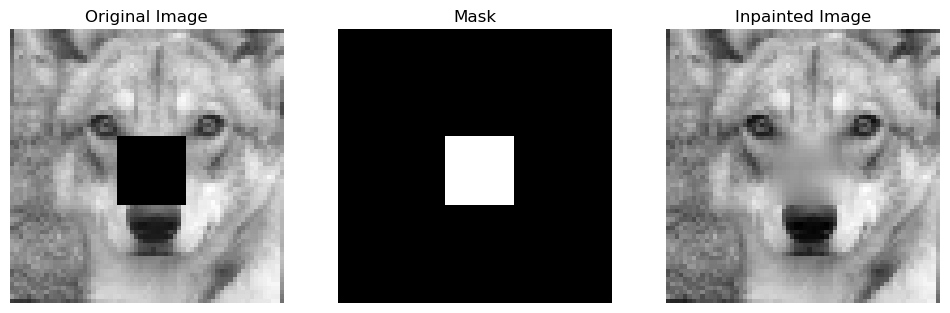

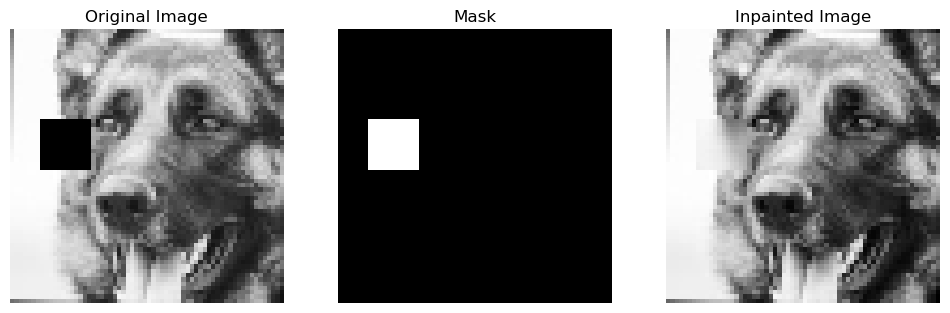

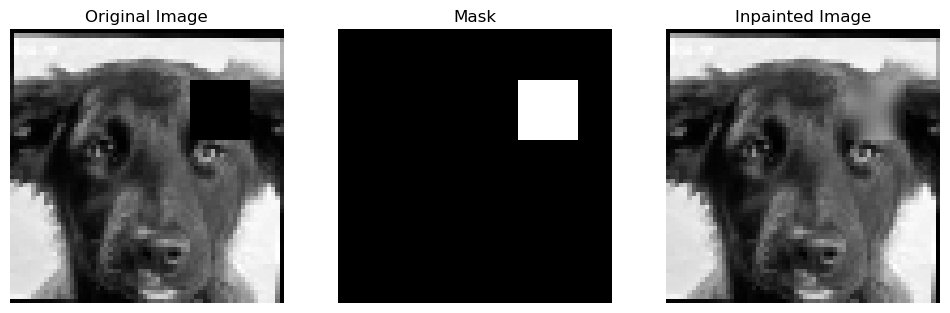

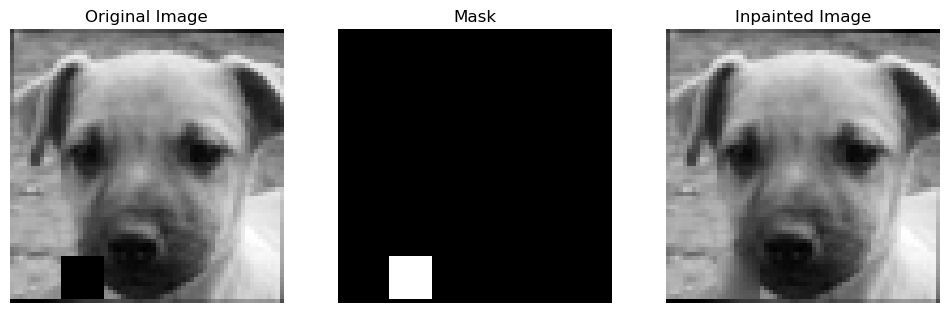

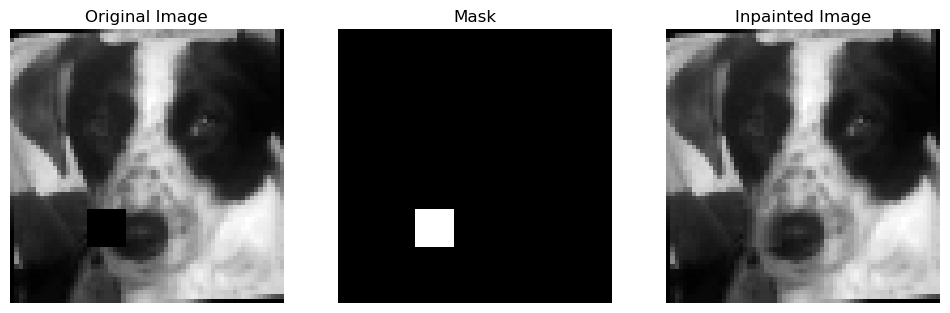

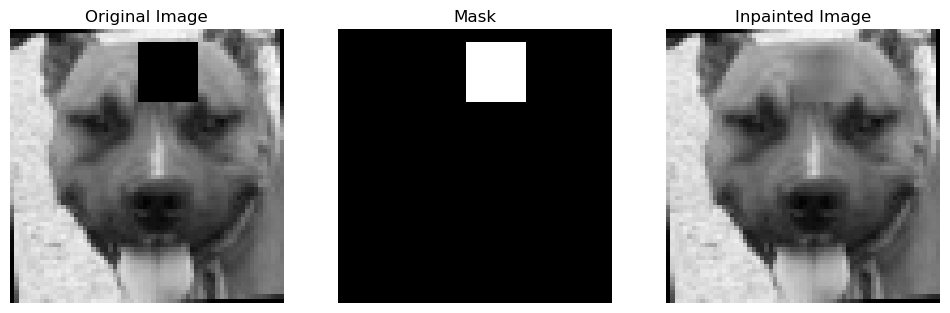

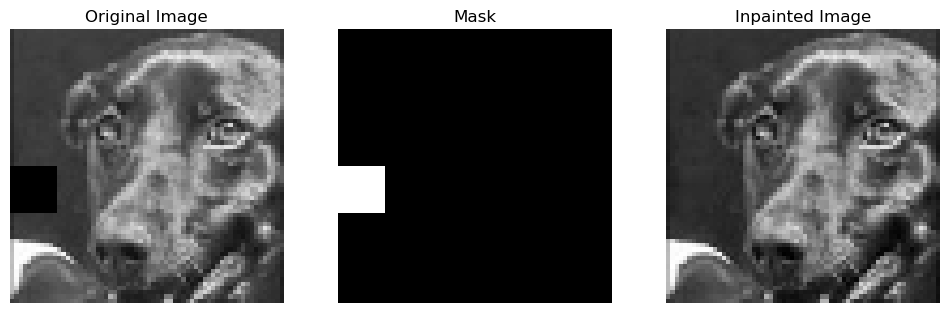

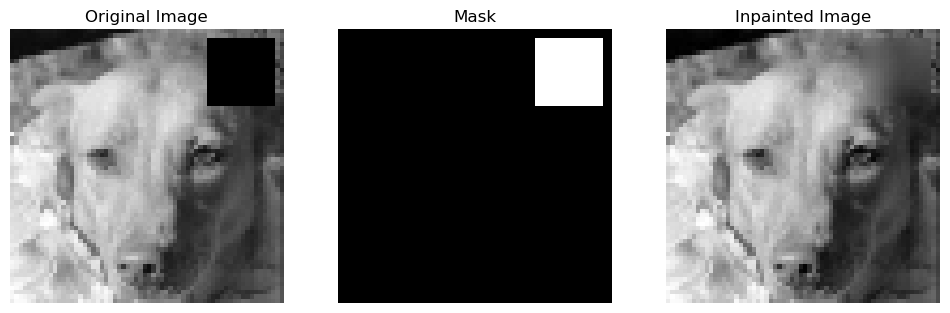

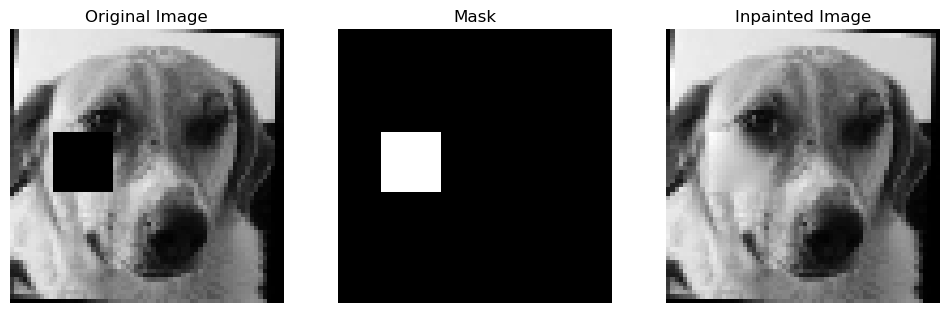

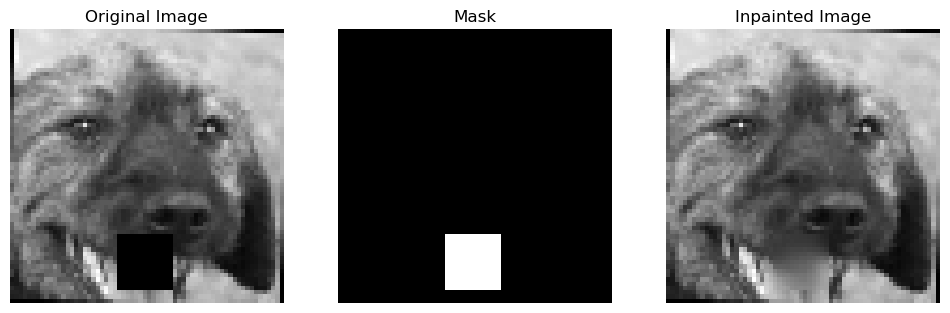

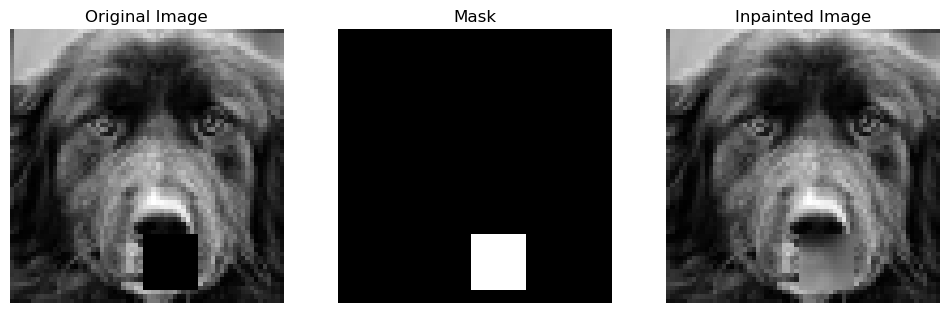

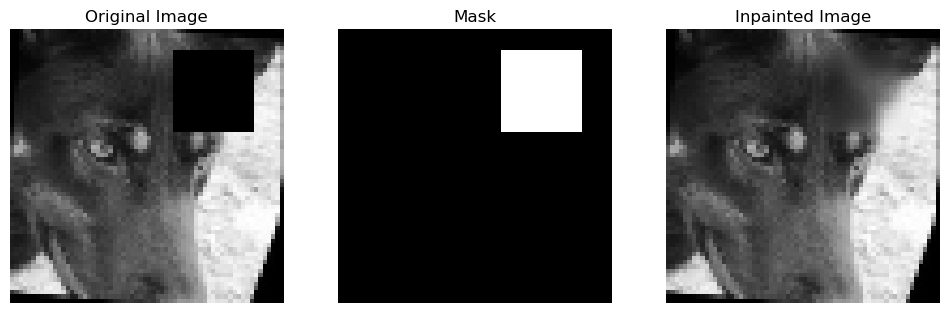

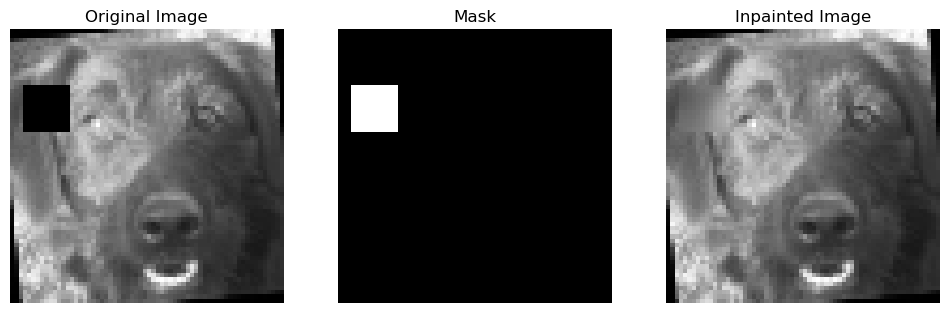

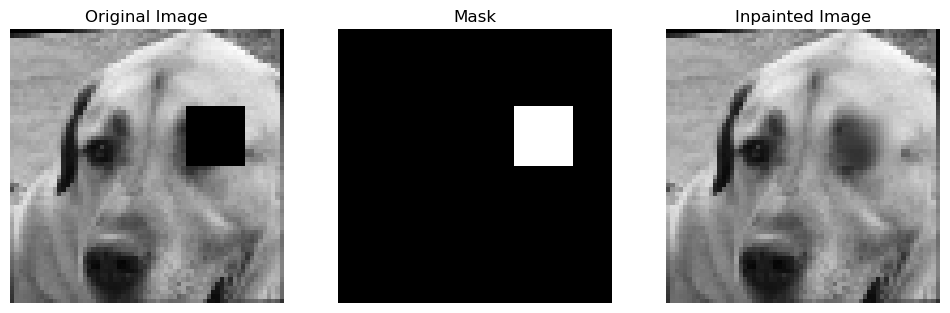

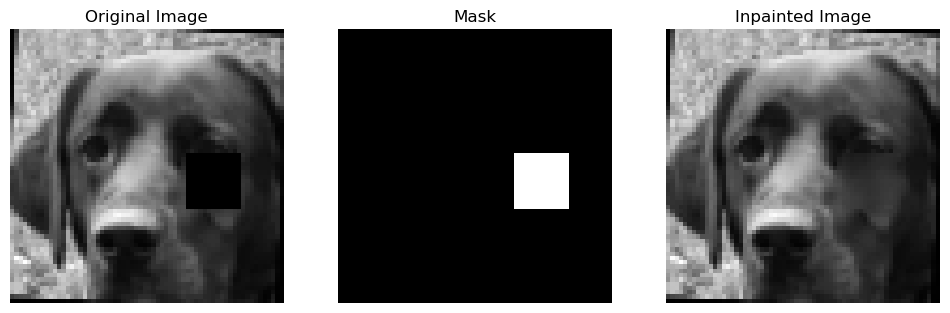

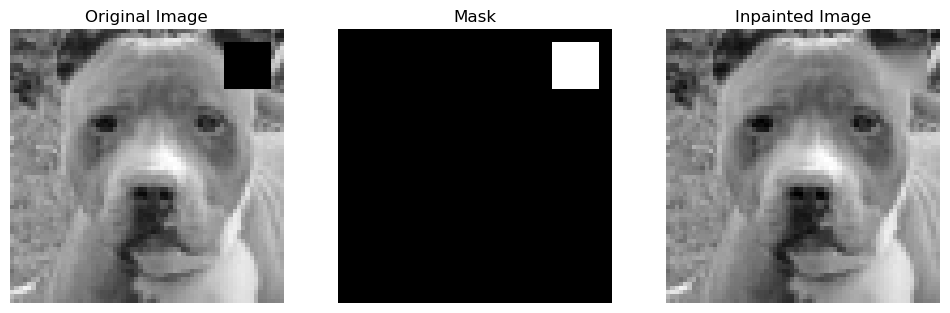

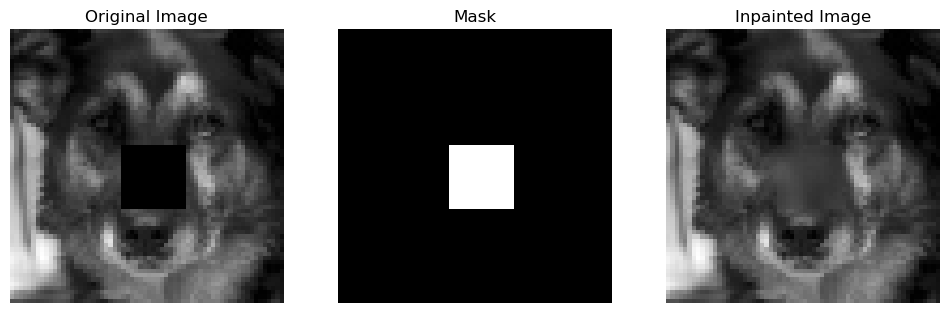

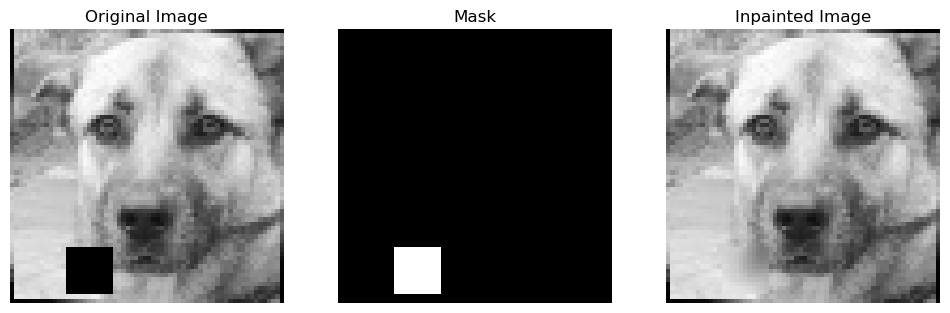

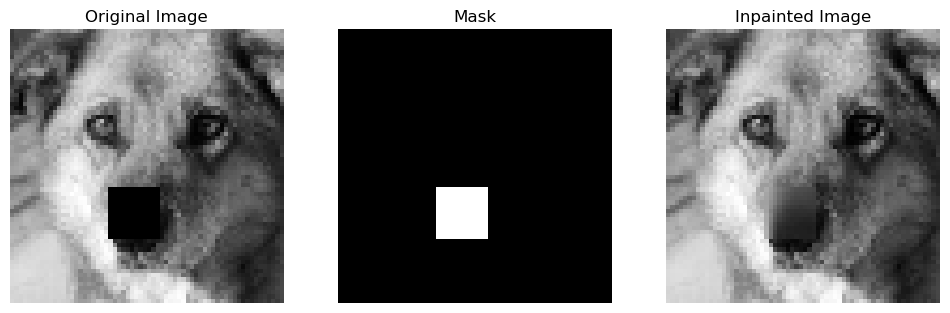

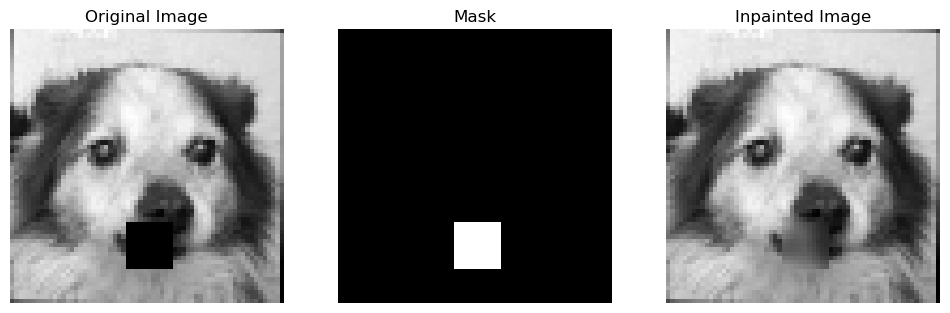

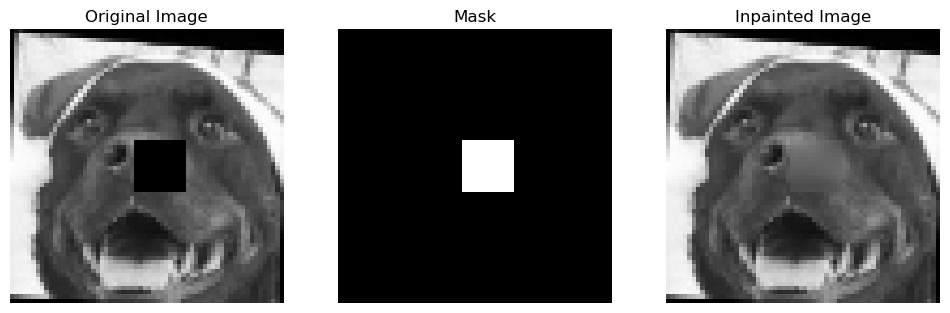

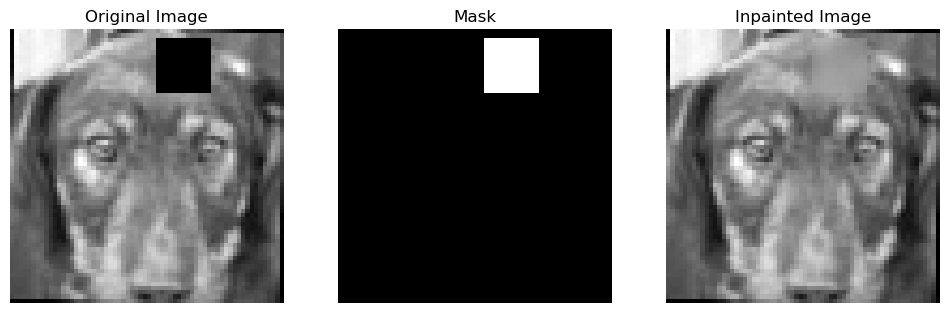

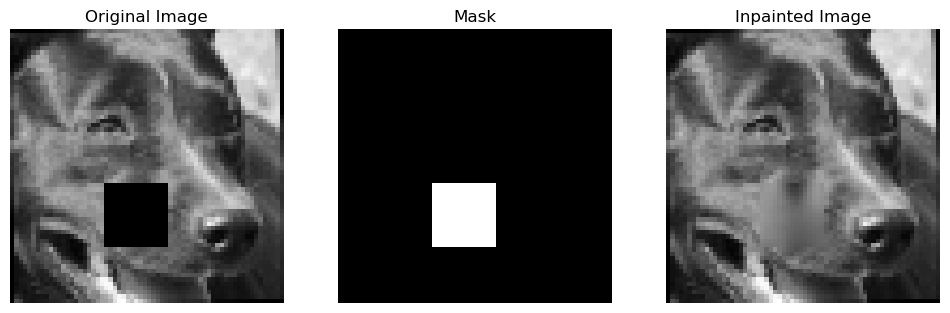

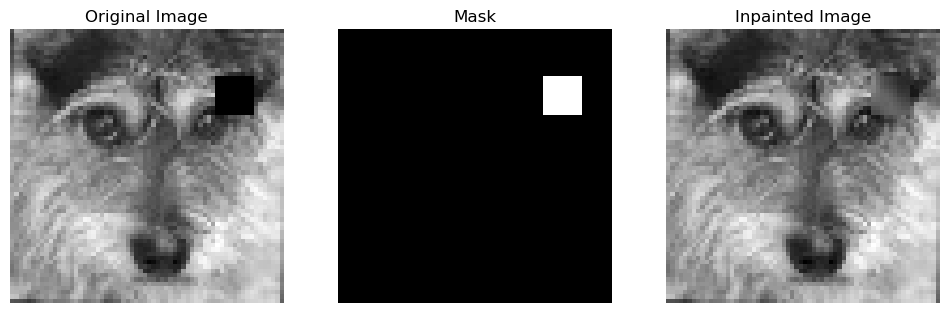

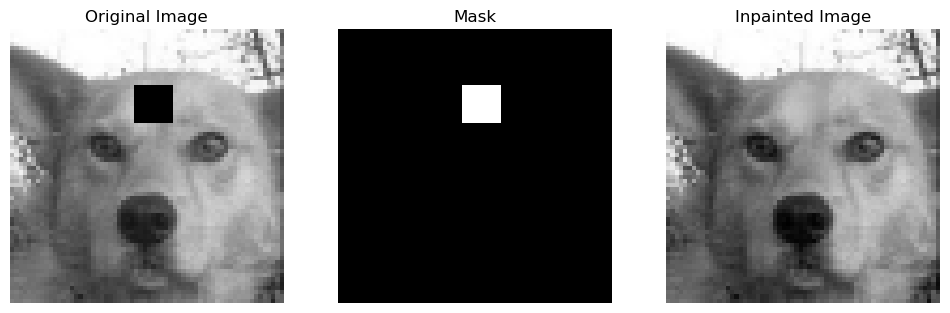

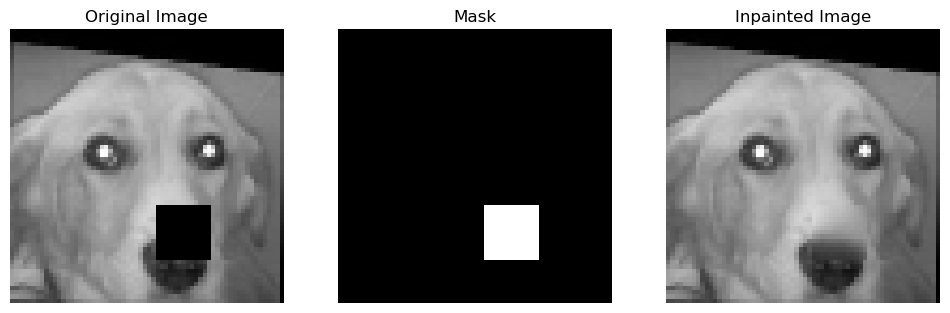

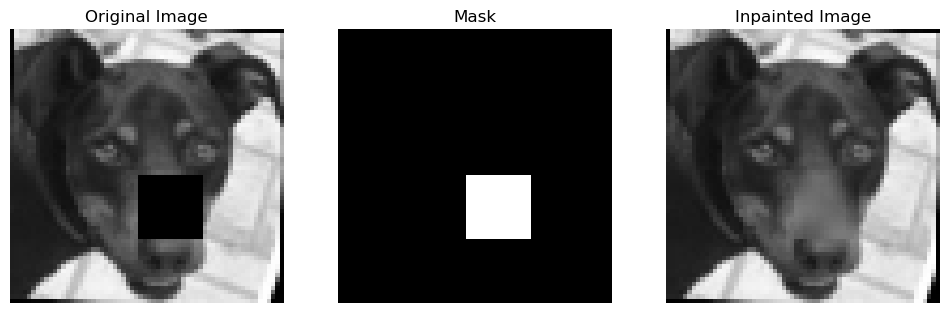

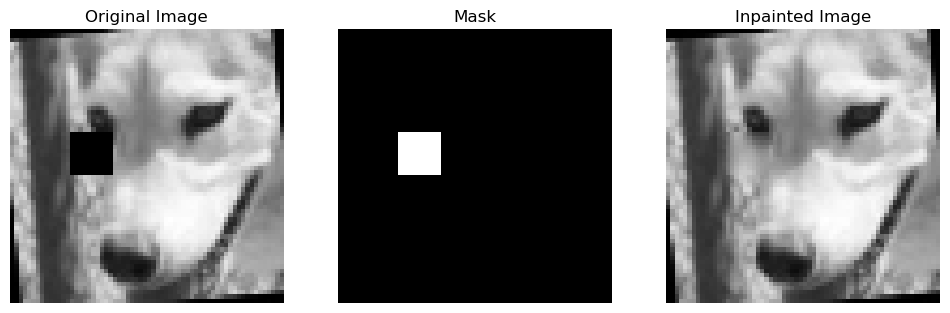

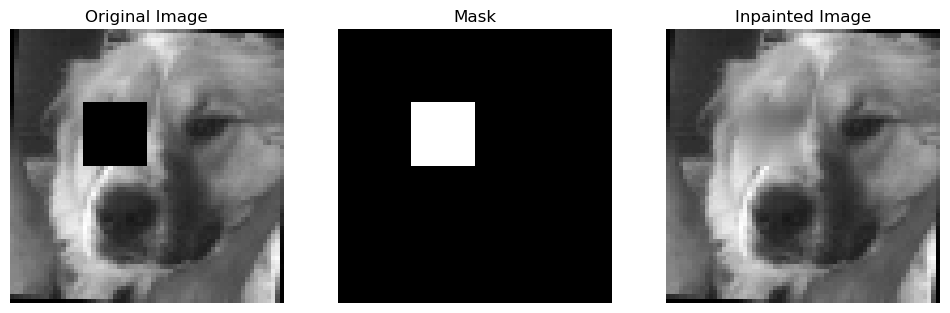

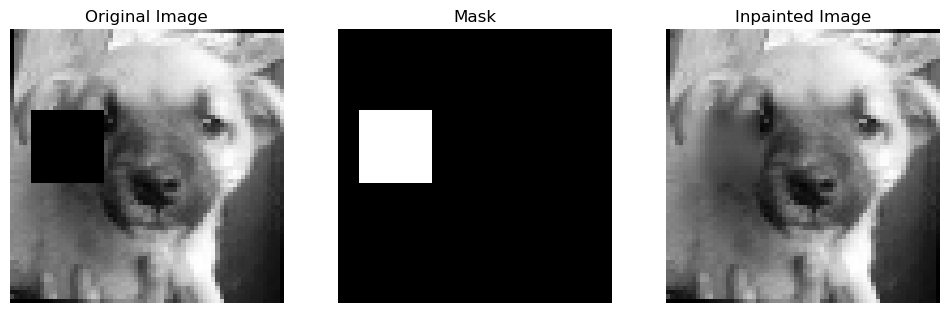

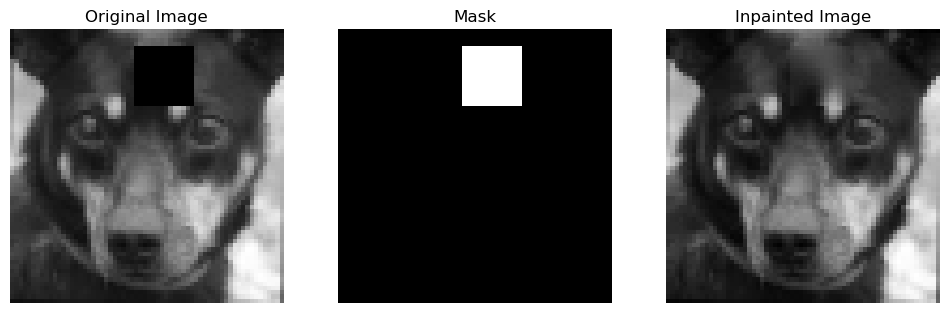

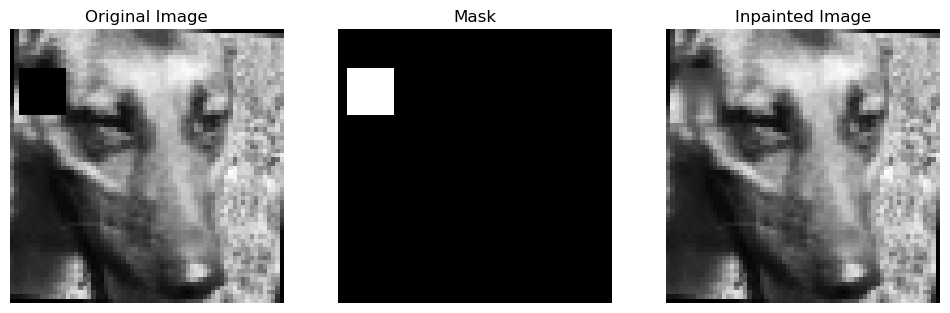

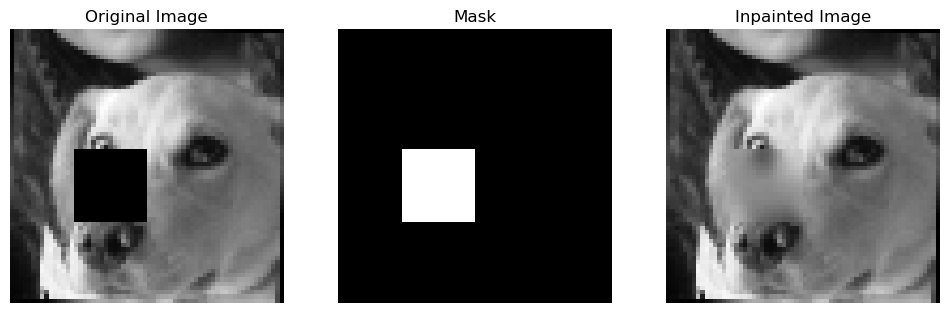

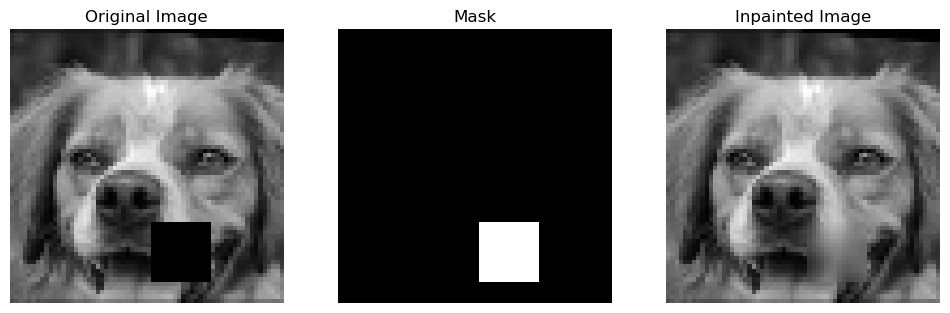

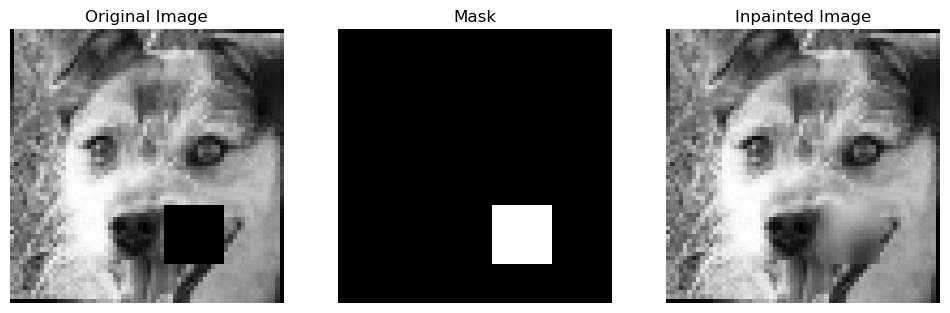

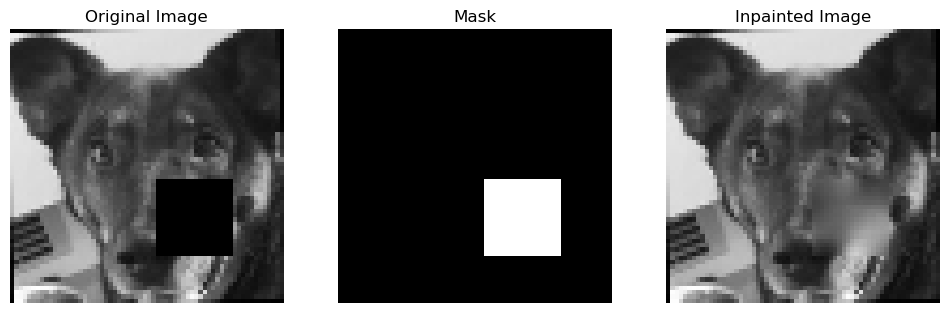

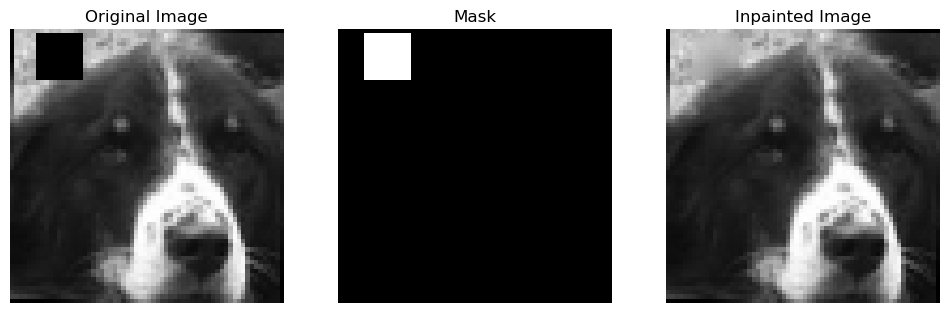

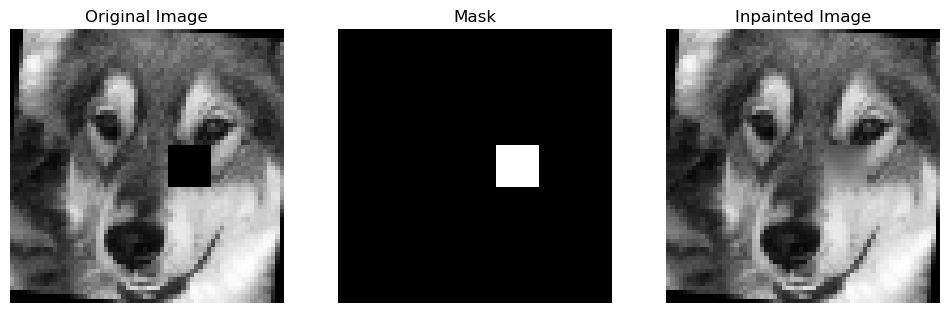

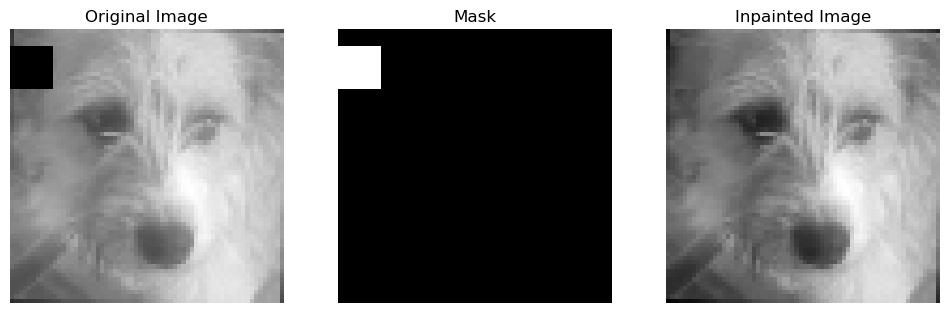

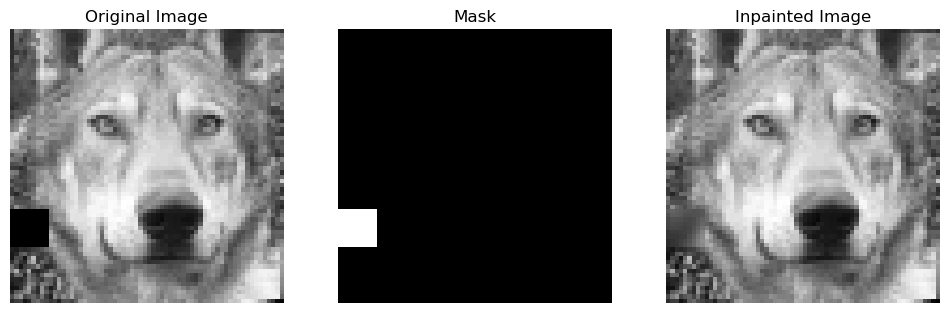

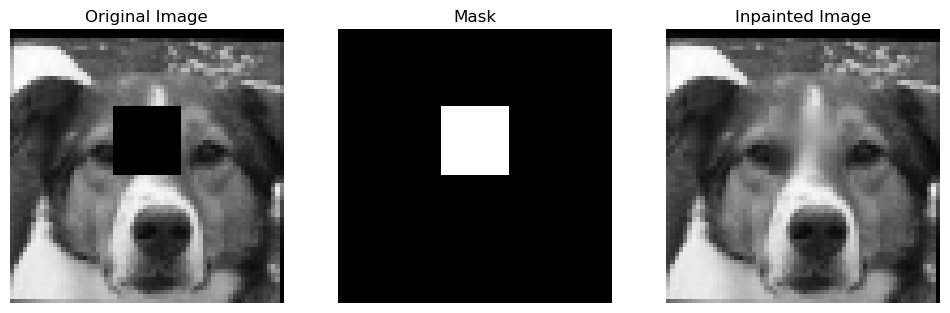

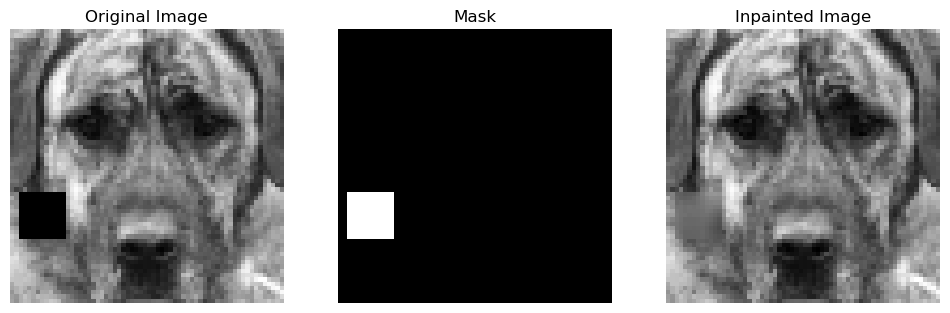

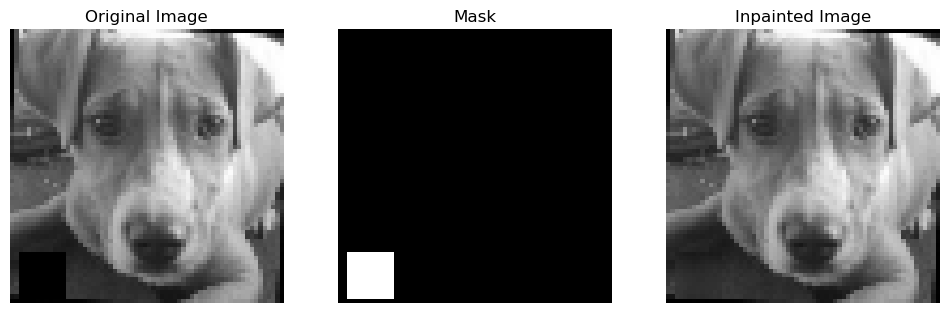

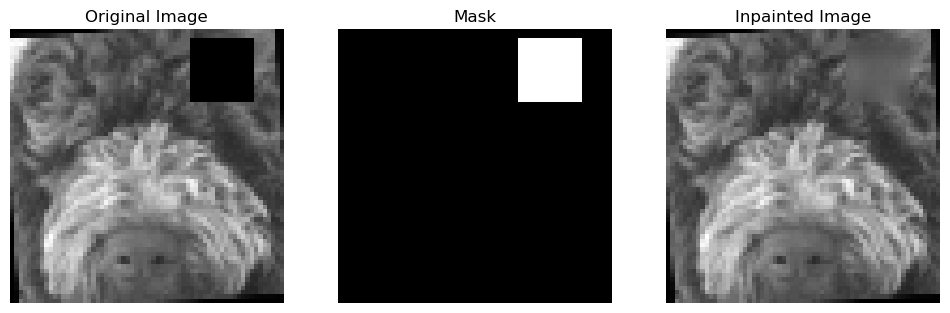

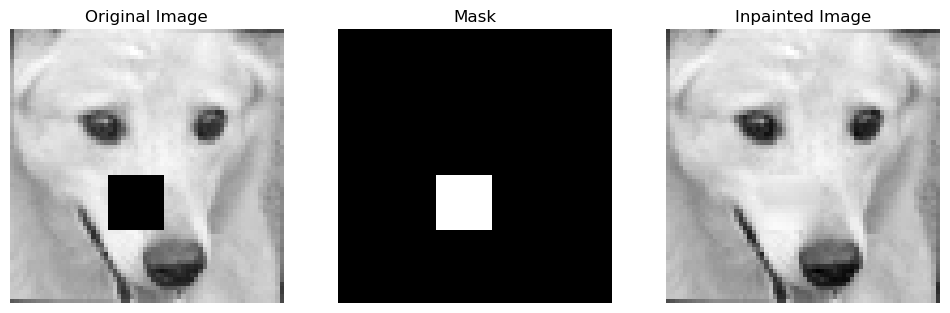

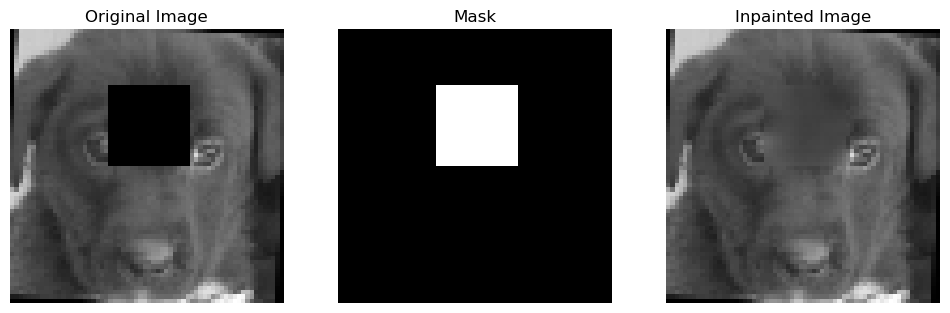

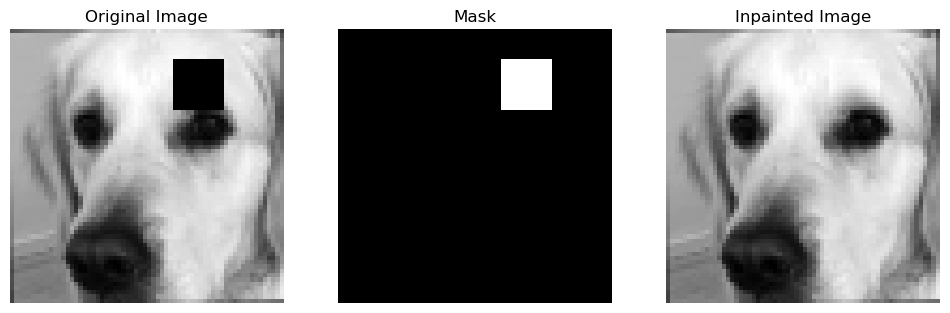

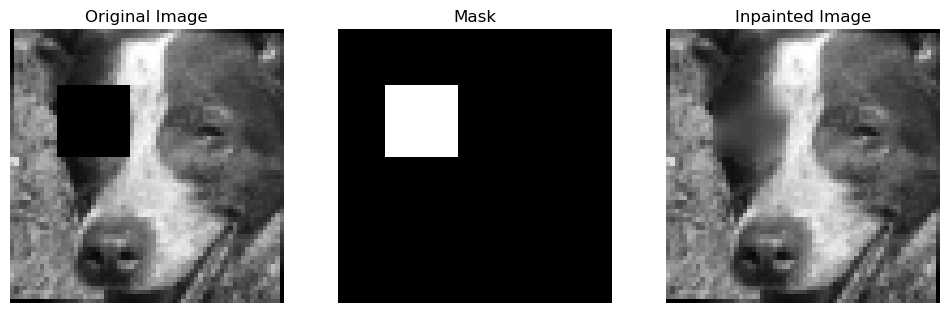

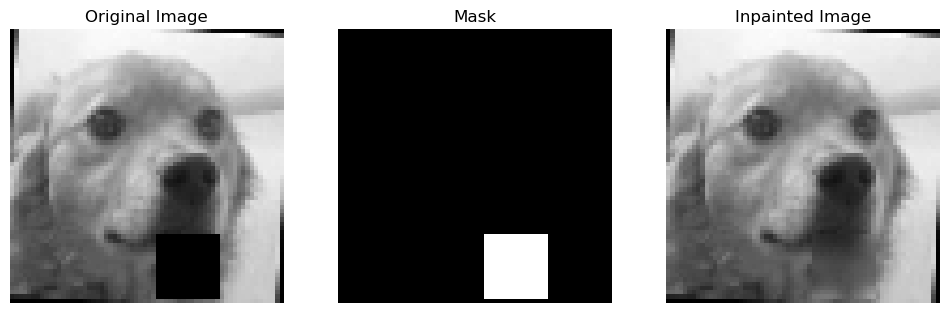

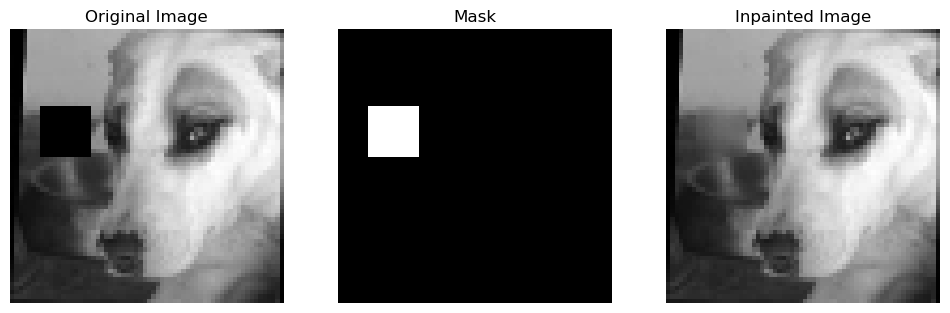

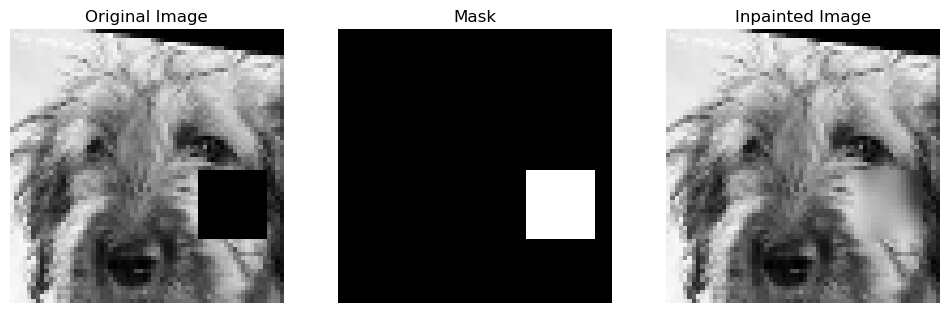

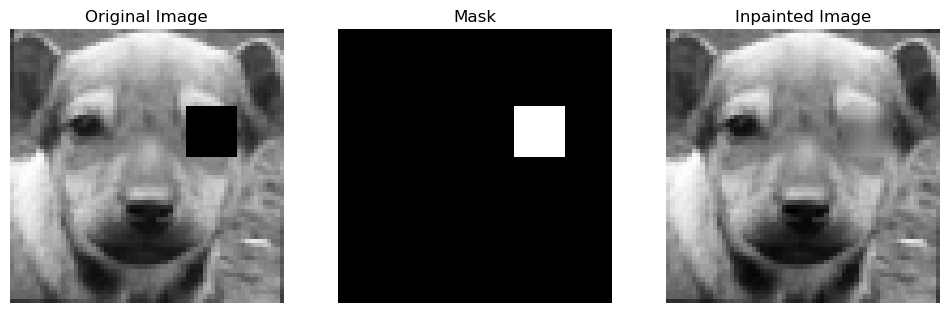

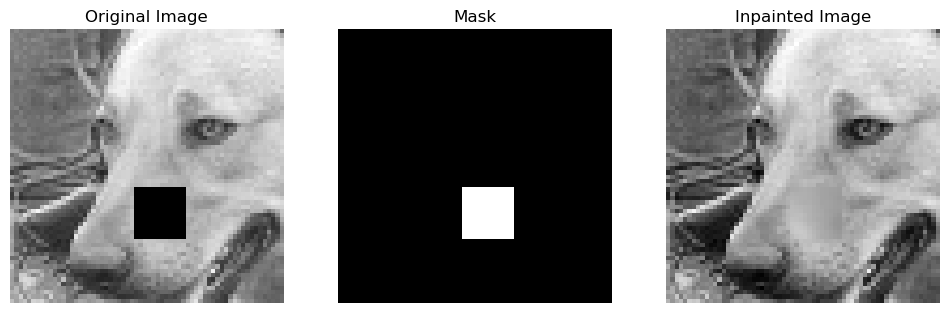

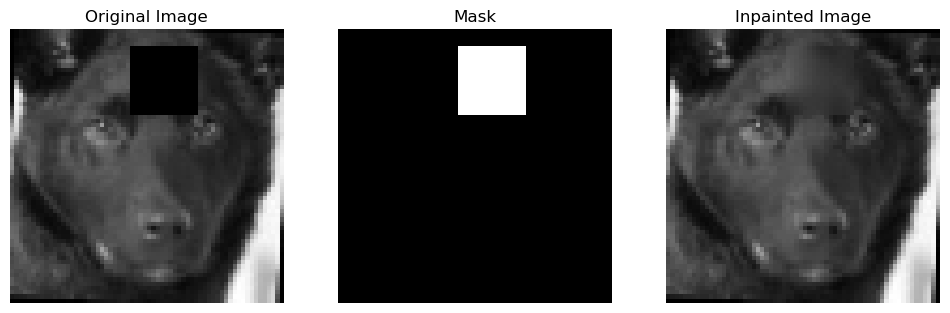

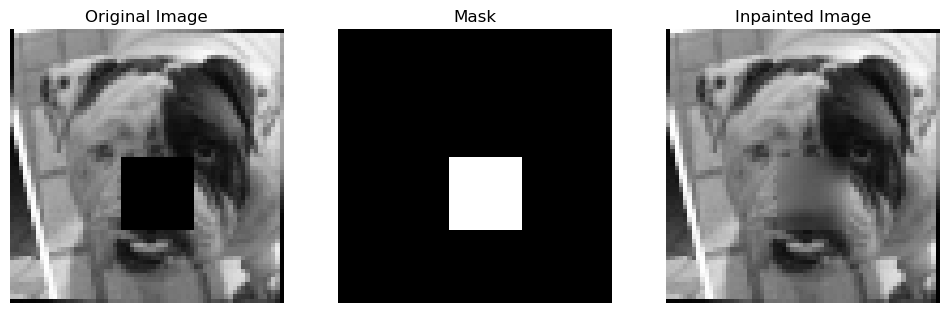

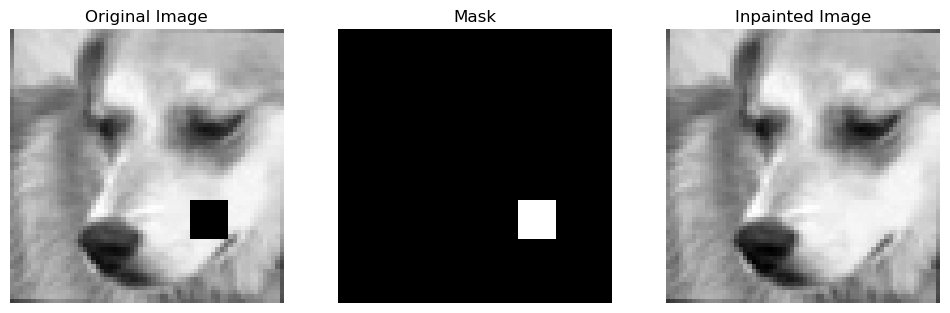

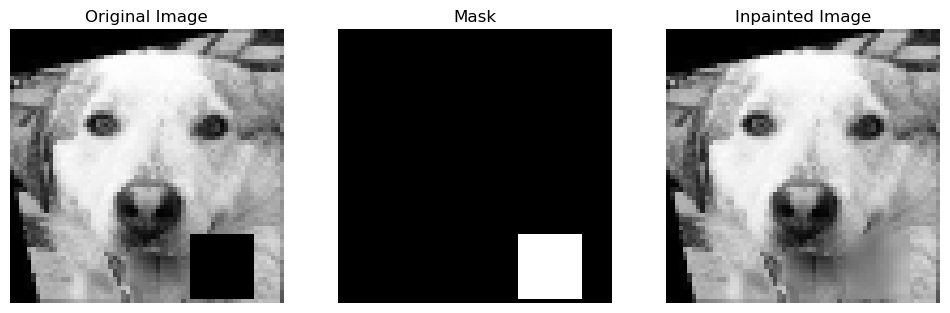

In [ ]:
for idx, (test_image, _, test_mask) in enumerate(test_loader):
    inpainted_result = inpaint_image(model, test_image.squeeze(), test_mask)

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.imshow(test_image.squeeze().numpy(), cmap='gray')
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(test_mask.squeeze().numpy(), cmap='gray')
    plt.title('Mask')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(inpainted_result.squeeze().numpy(), cmap='gray')
    plt.title('Inpainted Image')
    plt.axis('off')

    plt.show()